<div style="background:linear-gradient(135deg,#1a1a2e,#16213e,#0f3460);padding:50px 40px;border-radius:16px;text-align:center;margin-bottom:20px;">
<h1 style="color:#e0e0ff;font-size:2.4em;margin:0 0 12px;">TPU Membrane Permeability Model</h1>
<h3 style="color:#a0b0ff;font-weight:400;margin:0 0 16px;">A Mathematical & Visual Guide to Three ML Models</h3>
<p style="color:#7080cc;font-size:1em;">Polynomial Ridge Regression &nbsp;·&nbsp; Neural Network Ensemble &nbsp;·&nbsp; Gaussian Process</p>
</div>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.metrics import r2_score
from scipy.optimize import minimize

plt.rcParams.update({
    'figure.facecolor': '#12121f',
    'axes.facecolor':   '#1a1a2e',
    'axes.edgecolor':   '#3a3a5e',
    'axes.labelcolor':  '#c0c0e0',
    'xtick.color':      '#c0c0e0',
    'ytick.color':      '#c0c0e0',
    'text.color':       '#e0e0ff',
    'grid.color':       '#2a2a4e',
    'grid.linestyle':   '--',
    'font.size':        11,
})
print('All imports successful')


All imports successful


---
## 1  Experimental Dataset

Each data point is a **TPU membrane blend** characterised by four component fractions and one measured permeability value.
All compositions sum to 100 %.

| Symbol | Component | Trade name |
|--------|-----------|------------|
| S1 | Sparsa 1 | 27G26 |
| S2 | Sparsa 2 | 30G25 |
| C1 | Carbosil 1 | 2080A |
| C2 | Carbosil 2 | 2090A |


In [2]:
PHENOL_DATA = [
    {'id':'M-01',    'S1':100,'S2':  0,'C1':  0,'C2':  0,'P':1.60618e-6},
    {'id':'M-02',    'S1':  0,'S2':100,'C1':  0,'C2':  0,'P':7.55954e-7},
    {'id':'M-03',    'S1':  0,'S2':  0,'C1':100,'C2':  0,'P':1.68063e-7},
    {'id':'M-03(3)','S1':  0,'S2':  0,'C1':100,'C2':  0,'P':2.17540e-7},
    {'id':'M-05',    'S1': 60,'S2': 40,'C1':  0,'C2':  0,'P':5.75051e-7},
    {'id':'M-07',    'S1': 30,'S2': 70,'C1':  0,'C2':  0,'P':3.39749e-8},
    {'id':'M-11',    'S1': 10,'S2': 20,'C1': 70,'C2':  0,'P':1.59367e-7},
]

MCRESOL_DATA = [
    {'id':'M-02',    'S1':  0,'S2':100,'C1':  0,'C2':  0,'P':1.02150e-7},
    {'id':'M-04(2)','S1':  0,'S2':  0,'C1':  0,'C2':100,'P':1.46250e-7},
    {'id':'M-07',    'S1': 30,'S2': 70,'C1':  0,'C2':  0,'P':9.75280e-8},
    {'id':'M-09',    'S1': 60,'S2': 10,'C1': 30,'C2':  0,'P':5.05120e-8},
    {'id':'M-11',    'S1': 10,'S2': 20,'C1': 70,'C2':  0,'P':1.09746e-7},
    {'id':'M-15',    'S1':  0,'S2': 50,'C1': 50,'C2':  0,'P':1.81053e-7},
    {'id':'M-20',    'S1':  0,'S2': 60,'C1': 20,'C2': 20,'P':1.82590e-7},
    {'id':'M-22',    'S1': 37,'S2': 63,'C1':  0,'C2':  0,'P':4.13480e-7},
]

GLUCOSE_DATA = [
    {'id':'G-01','S1':0,'S2':  0,'C1':100,'C2':0,'P':1.00e-13},
    {'id':'G-02','S1':0,'S2': 30,'C1': 70,'C2':0,'P':8.30e-11},
    {'id':'G-03','S1':0,'S2': 40,'C1': 60,'C2':0,'P':7.80e-10},
    {'id':'G-04','S1':0,'S2': 60,'C1': 40,'C2':0,'P':9.68e-9},
    {'id':'G-05','S1':0,'S2': 80,'C1': 20,'C2':0,'P':2.12e-8},
    {'id':'G-06','S1':0,'S2':100,'C1':  0,'C2':0,'P':2.19e-8},
]

def to_df(data):
    df = pd.DataFrame(data)
    df['logP'] = np.log10(df['P'])
    return df

ph = to_df(PHENOL_DATA)
mc = to_df(MCRESOL_DATA)
gl = to_df(GLUCOSE_DATA)

print('Phenol data:', len(ph), 'points')
print('M-Cresol data:', len(mc), 'points')
print('Glucose data:', len(gl), 'points')
ph.head()


Phenol data: 7 points
M-Cresol data: 8 points
Glucose data: 6 points


,id,S1,S2,C1,C2,P,logP
0,M-01,100,0,0,0,1.606180e-06,-5.794206
1,M-02,0,100,0,0,7.559540e-07,-6.121505
2,M-03,0,0,100,0,1.680630e-07,-6.774528
3,M-03(3),0,0,100,0,2.175400e-07,-6.662461
4,M-05,60,40,0,0,5.750510e-07,-6.240294


---
## 2  Why log-transform permeability?

Permeability values span **many orders of magnitude** (e.g. 1e-13 to 1e-6 cm/s for glucose vs phenol).
Training on raw values biases all models toward the largest numbers.

We define the target variable:

$$y = \log_{10}(P)$$

This compresses the range so that a change from 1e-8 to 1e-7 is treated the same as 1e-7 to 1e-6.
All models are trained on **y** and predictions are inverted with $P = 10^y$ for display.


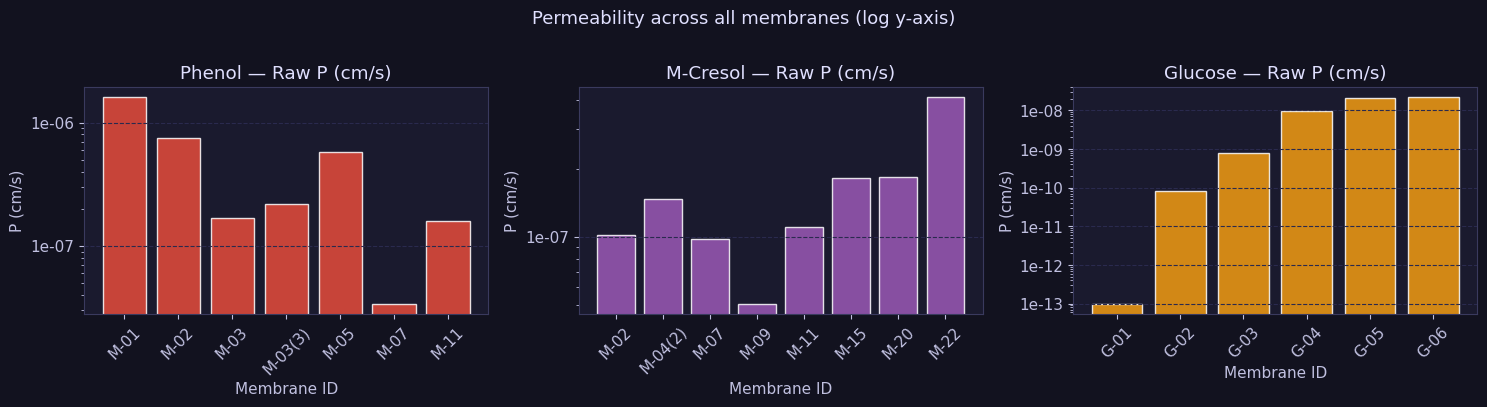

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
datasets = [('Phenol', ph, '#e74c3c'), ('M-Cresol', mc, '#9b59b6'), ('Glucose', gl, '#f39c12')]

for ax, (name, df, col) in zip(axes, datasets):
    ax.bar(df['id'], df['P'], color=col, alpha=0.85, edgecolor='#ffffff30')
    ax.set_title(f'{name} — Raw P (cm/s)', color='#e0e0ff')
    ax.set_xlabel('Membrane ID')
    ax.set_ylabel('P (cm/s)')
    ax.tick_params(axis='x', rotation=45)
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,_: f'{v:.0e}'))
    ax.grid(axis='y')

plt.suptitle('Permeability across all membranes (log y-axis)', color='#e0e0ff', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()


---
## 3  Composition Space Visualisation

Because compositions must sum to 100 % the search space is a **3-simplex** (tetrahedron) in 4-D.
We visualise two 2-D slices: (S1 vs S2) and (S2 vs C1), colouring by log-permeability.


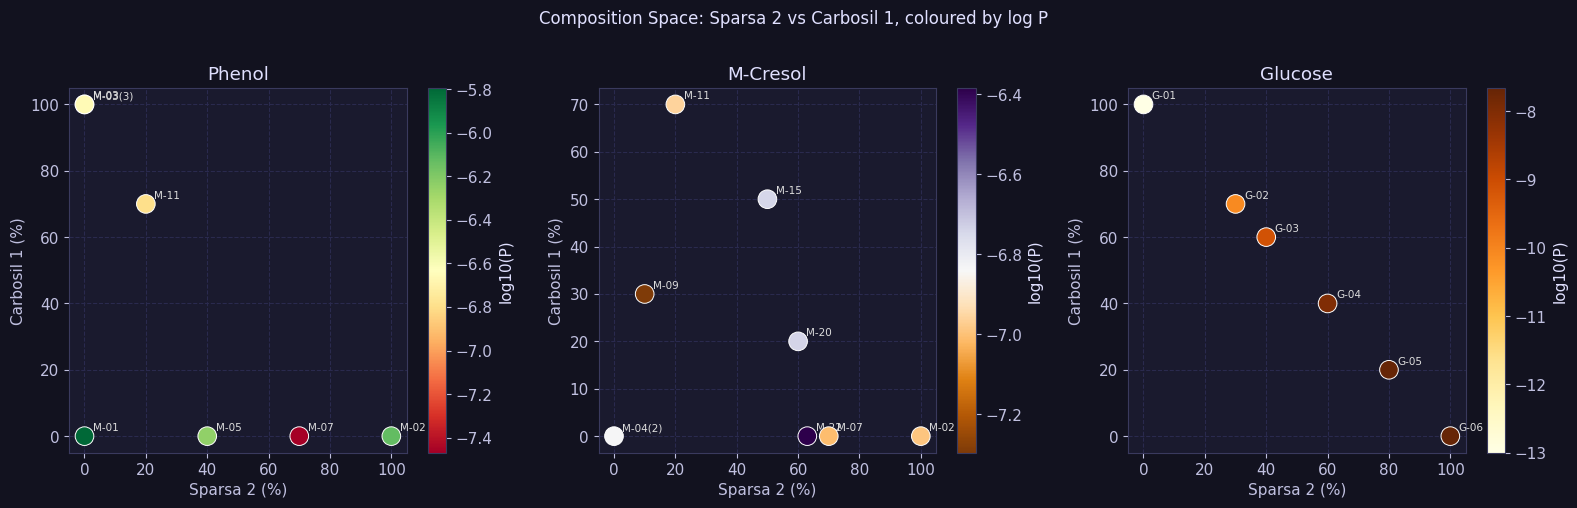

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
datasets_all = [('Phenol', ph, 'RdYlGn'), ('M-Cresol', mc, 'PuOr'), ('Glucose', gl, 'YlOrBr')]

for ax, (name, df, cmap) in zip(axes, datasets_all):
    sc = ax.scatter(df['S2'], df['C1'], c=df['logP'], cmap=cmap,
                   s=180, edgecolors='white', linewidths=0.7, zorder=5)
    for _, row in df.iterrows():
        ax.annotate(row['id'], (row['S2'], row['C1']),
                    textcoords='offset points', xytext=(6,4),
                    fontsize=7.5, color='#ddd')
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('log10(P)', color='#e0e0ff')
    cbar.ax.yaxis.set_tick_params(color='#c0c0e0')
    ax.set_xlabel('Sparsa 2 (%)')
    ax.set_ylabel('Carbosil 1 (%)')
    ax.set_title(f'{name}', color='#e0e0ff')
    ax.grid(True)

plt.suptitle('Composition Space: Sparsa 2 vs Carbosil 1, coloured by log P', color='#e0e0ff', fontsize=12, y=1.01)
plt.tight_layout()
plt.show()


---
## 4  Polynomial Ridge Regression

### 4.1  Feature map

Raw input $\mathbf{x} = [x_1, x_2, x_3, x_4]$ (four composition fractions, each in [0,1]).
We apply a **degree-2 polynomial expansion** to capture interaction effects:

$$\phi(\mathbf{x}) = [1,\; x_1,\; x_2,\; x_3,\; x_4,\; x_1^2,\; x_1 x_2,\; x_1 x_3,\; \ldots,\; x_4^2]$$

For $d=4$ inputs, degree-2 expansion produces $\binom{4+2}{2} = 15$ features.

### 4.2  Ridge objective

We solve the regularised least-squares problem:

$$\min_{\mathbf{w}} \underbrace{\|\Phi\mathbf{w} - \mathbf{y}\|^2}_{\text{fit}} + \underbrace{\alpha\|\mathbf{w}\|^2}_{\text{regularisation}}$$

where $\Phi$ is the $N \times 15$ design matrix (rows = data points, columns = polynomial features), $\mathbf{y}$ is the vector of log-permeabilities, and $\alpha = 1.0$ is the penalty strength.

### 4.3  Closed-form solution

Differentiating and setting to zero:

$$\mathbf{w}^* = (\Phi^\top \Phi + \alpha I)^{-1} \Phi^\top \mathbf{y}$$

The $\alpha I$ term makes the matrix invertible even when $N < 15$ (which is our case), and shrinks weights toward zero to prevent overfitting.

### 4.4  Prediction

$$\hat{y} = \phi(\mathbf{x})^\top \mathbf{w}^* \quad \Rightarrow \quad \hat{P} = 10^{\hat{y}}$$


In [5]:
def get_XY(df):
    X = df[['S1','S2','C1','C2']].values / 100.0
    y = df['logP'].values
    return X, y

def train_ridge(df):
    X, y = get_XY(df)
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=True)),
        ('ridge', Ridge(alpha=1.0))
    ])
    model.fit(X, y)
    return model, X, y

# Show the polynomial feature expansion for one example
pf = PolynomialFeatures(degree=2, include_bias=True)
x_demo = np.array([[0.1, 0.2, 0.7, 0.0]])
expanded = pf.fit_transform(x_demo)
names = pf.get_feature_names_out(['S1','S2','C1','C2'])
print('Degree-2 polynomial features (15 total):')
for n, v in zip(names, expanded[0]):
    print(f'  {n:12s} = {v:.4f}')


Degree-2 polynomial features (15 total):
  1            = 1.0000
  S1           = 0.1000
  S2           = 0.2000
  C1           = 0.7000
  C2           = 0.0000
  S1^2         = 0.0100
  S1 S2        = 0.0200
  S1 C1        = 0.0700
  S1 C2        = 0.0000
  S2^2         = 0.0400
  S2 C1        = 0.1400
  S2 C2        = 0.0000
  C1^2         = 0.4900
  C1 C2        = 0.0000
  C2^2         = 0.0000


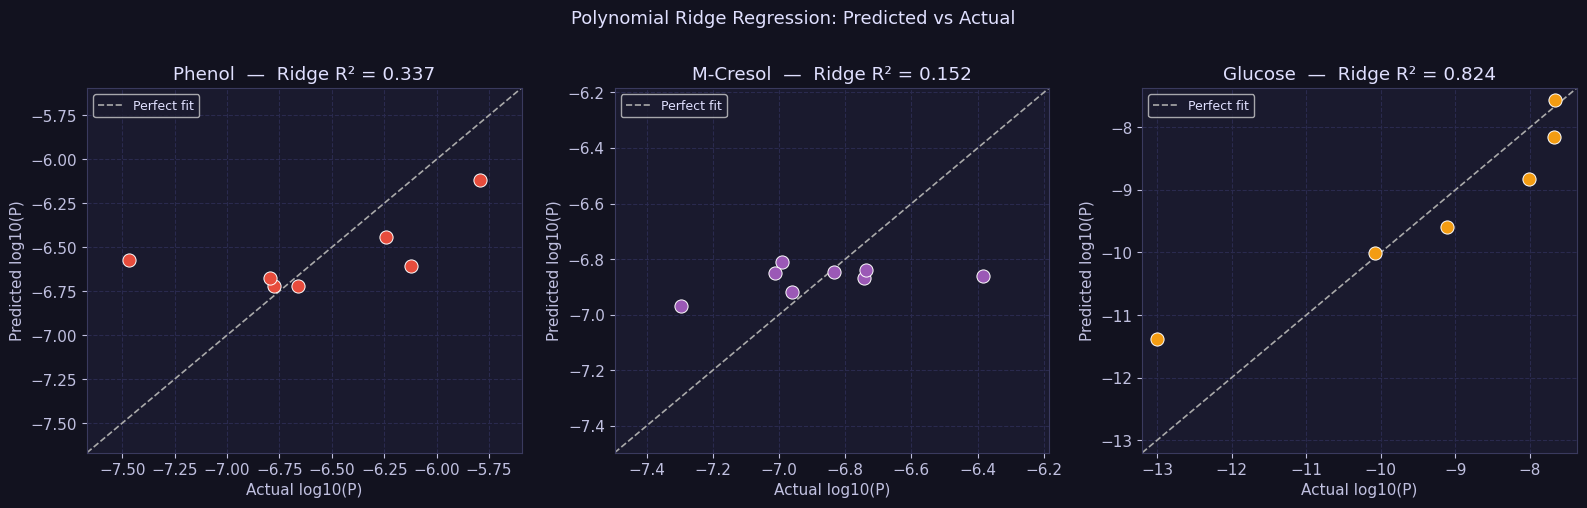

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, (name, df, col) in zip(axes, datasets):
    model, X, y = train_ridge(df)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    ax.scatter(y, y_pred, c=col, s=90, edgecolors='white', lw=0.7, zorder=5)
    lims = [min(y.min(), y_pred.min())-0.2, max(y.max(), y_pred.max())+0.2]
    ax.plot(lims, lims, '--', color='#aaa', lw=1.2, label='Perfect fit')
    ax.set_xlim(lims); ax.set_ylim(lims)
    ax.set_xlabel('Actual log10(P)')
    ax.set_ylabel('Predicted log10(P)')
    ax.set_title(f'{name}  —  Ridge R² = {r2:.3f}', color='#e0e0ff')
    ax.legend(fontsize=9)
    ax.grid(True)

plt.suptitle('Polynomial Ridge Regression: Predicted vs Actual', color='#e0e0ff', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()


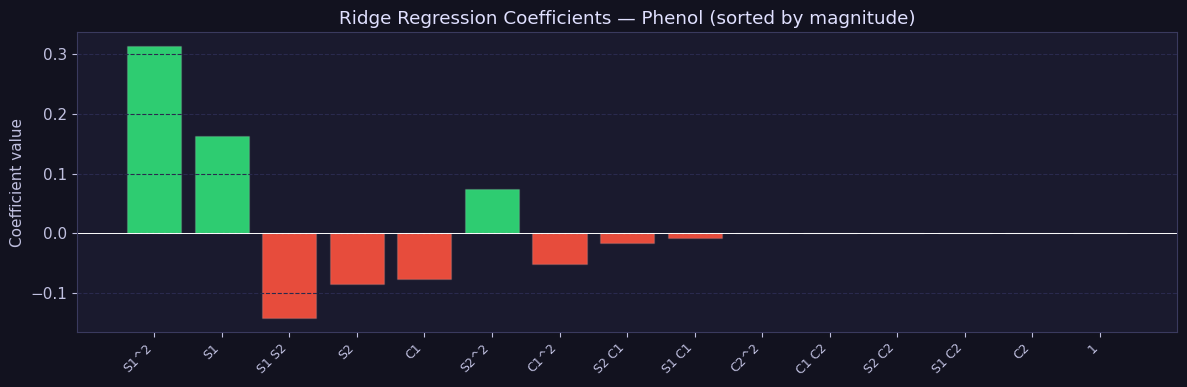

In [7]:
# Visualise ridge regression coefficients (phenol)
model, X, y = train_ridge(ph)
coef = model.named_steps['ridge'].coef_
names = model.named_steps['poly'].get_feature_names_out(['S1','S2','C1','C2'])
# Sort by magnitude
order = np.argsort(np.abs(coef))[::-1]

fig, ax = plt.subplots(figsize=(12, 4))
bar_colors = ['#e74c3c' if c < 0 else '#2ecc71' for c in coef[order]]
ax.bar(range(len(coef)), coef[order], color=bar_colors, edgecolor='#ffffff20')
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names[order], rotation=45, ha='right', fontsize=9)
ax.axhline(0, color='white', lw=0.7)
ax.set_ylabel('Coefficient value')
ax.set_title('Ridge Regression Coefficients — Phenol (sorted by magnitude)', color='#e0e0ff')
ax.grid(axis='y')
plt.tight_layout()
plt.show()


---
## 5  Neural Network Ensemble

### 5.1  Architecture

A **two-layer feedforward network** with sigmoid activation:

$$\mathbf{h} = \sigma(\mathbf{x}_n W_1 + \mathbf{b}_1), \quad \hat{y}_n = \mathbf{h} W_2 + b_2$$

where $\sigma(z) = \frac{1}{1+e^{-z}}$ applied element-wise, $W_1 \in \mathbb{R}^{4 \times 6}$, $W_2 \in \mathbb{R}^{6 \times 1}$, and hidden size = 6.

### 5.2  Input / output normalisation

Before training, inputs and outputs are z-score normalised:

$$\mathbf{x}_n = \frac{\mathbf{x} - \bar{\mathbf{x}}}{\sigma_{\mathbf{x}}}, \quad y_n = \frac{y - \bar{y}}{\sigma_y}$$

Predictions are back-transformed: $\hat{y} = \hat{y}_n \cdot \sigma_y + \bar{y}$.

### 5.3  He initialisation

Weights are initialised from a zero-mean Gaussian scaled to preserve signal variance:

$$W \sim \mathcal{N}\!\left(0,\; \frac{2}{n_{\text{in}}}\right)$$

This prevents vanishing/exploding gradients, especially important with sigmoid activations.

### 5.4  Loss and regularisation

Mean-squared error loss with L2 weight decay ($\lambda = 10^{-3}$):

$$\mathcal{L} = \frac{1}{N}\sum_{i=1}^N (\hat{y}_i - y_i)^2 + \lambda(\|W_1\|^2 + \|W_2\|^2)$$

### 5.5  Adam optimiser

Adam maintains exponential moving averages of the gradient $m_t$ and its square $v_t$:

$$m_t = \beta_1 m_{t-1} + (1-\beta_1)g_t$$

$$v_t = \beta_2 v_{t-1} + (1-\beta_2)g_t^2$$

with bias-corrected estimates $\hat{m}_t = m_t / (1-\beta_1^t)$, $\hat{v}_t = v_t / (1-\beta_2^t)$.
The weight update is:

$$\theta_t = \theta_{t-1} - \eta \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \varepsilon}$$

Hyperparameters: $\eta = 10^{-3}$, $\beta_1 = 0.9$, $\beta_2 = 0.999$, $\varepsilon = 10^{-8}$.

### 5.6  Ensemble averaging

Seven networks are trained with different random seeds $s \in \{0,\ldots,6\}$. Final prediction:

$$\hat{y} = \frac{1}{7} \sum_{s=0}^{6} \hat{y}^{(s)}(\mathbf{x})$$

Variance of the ensemble mean is $\text{Var}[\hat{y}]/7$, so averaging reduces prediction noise by $\sqrt{7} \approx 2.6\times$.


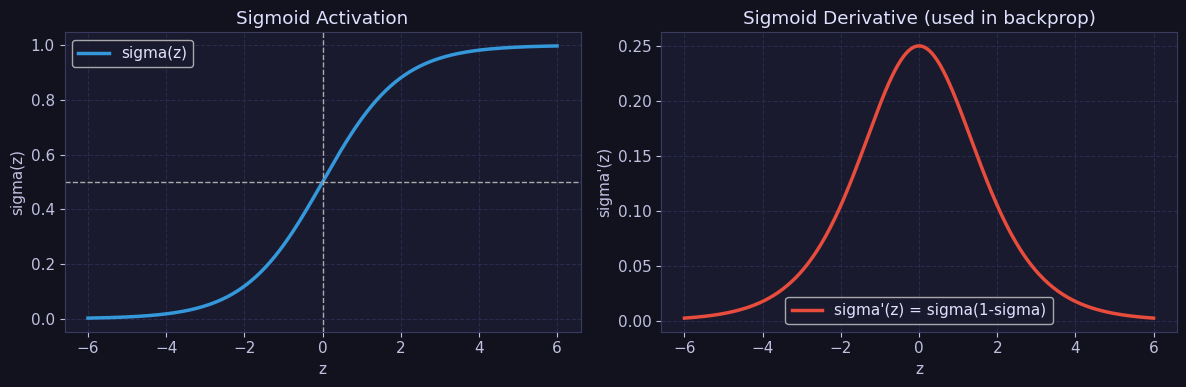

In [8]:
# Plot the sigmoid function and its derivative
z = np.linspace(-6, 6, 300)
sig = 1 / (1 + np.exp(-z))
dsig = sig * (1 - sig)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(z, sig, color='#3498db', lw=2.5, label='sigma(z)')
ax1.axhline(0.5, color='#aaa', lw=1, ls='--')
ax1.axvline(0, color='#aaa', lw=1, ls='--')
ax1.set_xlabel('z'); ax1.set_ylabel('sigma(z)')
ax1.set_title('Sigmoid Activation', color='#e0e0ff')
ax1.legend(); ax1.grid(True)

ax2.plot(z, dsig, color='#e74c3c', lw=2.5, label="sigma'(z) = sigma(1-sigma)")
ax2.set_xlabel('z'); ax2.set_ylabel("sigma'(z)")
ax2.set_title('Sigmoid Derivative (used in backprop)', color='#e0e0ff')
ax2.legend(); ax2.grid(True)

plt.tight_layout()
plt.show()


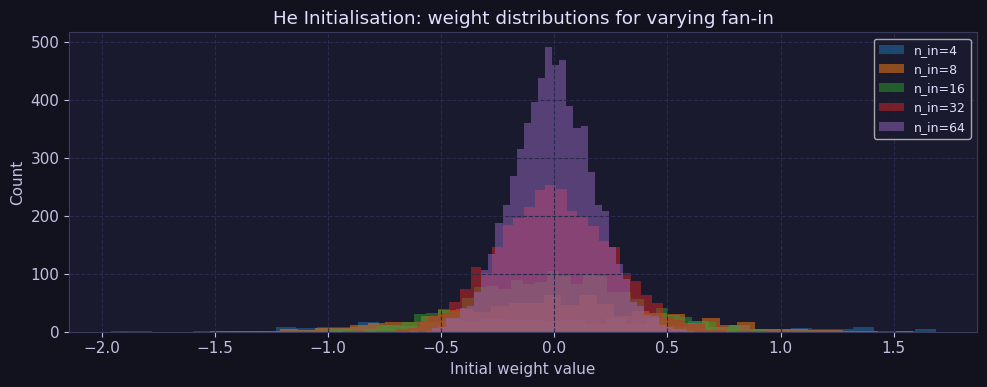

In [9]:
# Demonstrate He initialisation variance
np.random.seed(0)
n_in_vals = [4, 8, 16, 32, 64]
fig, ax = plt.subplots(figsize=(10, 4))
for n_in in n_in_vals:
    W = np.random.randn(n_in, 100) * np.sqrt(2.0 / n_in)
    ax.hist(W.flatten(), bins=40, alpha=0.5, label=f'n_in={n_in}')
ax.set_xlabel('Initial weight value')
ax.set_ylabel('Count')
ax.set_title('He Initialisation: weight distributions for varying fan-in', color='#e0e0ff')
ax.legend(fontsize=9)
ax.grid(True)
plt.tight_layout()
plt.show()


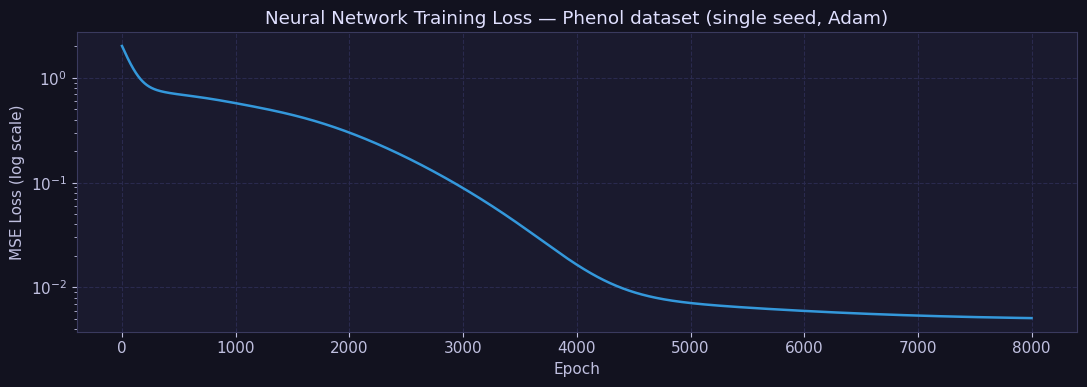

Final training loss: 0.005095


In [10]:
# Train NN and plot training loss curve (one seed, phenol)
X_ph, y_ph = get_XY(ph)
X_mean = X_ph.mean(0); X_std = X_ph.std(0) + 1e-8
y_mean = y_ph.mean();  y_std  = y_ph.std()  + 1e-8
Xn = (X_ph - X_mean) / X_std
yn = (y_ph - y_mean) / y_std

np.random.seed(0)
n_in, hidden = 4, 6
W1 = np.random.randn(n_in, hidden) * np.sqrt(2.0/n_in)
b1 = np.zeros(hidden)
W2 = np.random.randn(hidden, 1) * np.sqrt(2.0/hidden)
b2 = np.zeros(1)
lr, b1c, b2c, eps, wd = 1e-3, 0.9, 0.999, 1e-8, 1e-3
mW1=np.zeros_like(W1); vW1=np.zeros_like(W1)
mb1=np.zeros_like(b1); vb1=np.zeros_like(b1)
mW2=np.zeros_like(W2); vW2=np.zeros_like(W2)
mb2=np.zeros_like(b2); vb2=np.zeros_like(b2)

losses = []
for t in range(1, 8001):
    sig = lambda x: 1/(1+np.exp(-np.clip(x,-50,50)))
    h   = sig(Xn @ W1 + b1)
    out = h @ W2 + b2
    loss_vec = out[:,0] - yn
    losses.append((loss_vec**2).mean())
    gW2 = h.T @ loss_vec[:,None]/len(yn) + wd*W2
    gb2 = np.array([loss_vec.mean()])
    dh  = (loss_vec[:,None] @ W2.T) * h * (1-h)
    gW1 = Xn.T @ dh/len(yn) + wd*W1
    gb1 = dh.mean(0)
    bc1t = 1-b1c**t; bc2t = 1-b2c**t
    def adam(p,g,m,v):
        m=b1c*m+(1-b1c)*g; v=b2c*v+(1-b2c)*g**2
        p -= lr*(m/bc1t)/(np.sqrt(v/bc2t)+eps)
        return p,m,v
    W1,mW1,vW1=adam(W1,gW1,mW1,vW1)
    b1,mb1,vb1=adam(b1,gb1,mb1,vb1)
    W2,mW2,vW2=adam(W2,gW2,mW2,vW2)
    b2,mb2,vb2=adam(b2,gb2,mb2,vb2)

fig, ax = plt.subplots(figsize=(11, 4))
ax.semilogy(losses, color='#3498db', lw=1.8)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss (log scale)')
ax.set_title('Neural Network Training Loss — Phenol dataset (single seed, Adam)', color='#e0e0ff')
ax.grid(True)
plt.tight_layout()
plt.show()
print(f'Final training loss: {losses[-1]:.6f}')


---
## 7  Gaussian Process Regression — sklearn Implementation — Built From Scratch

> This section builds a GP **completely from scratch using only NumPy**, step by step.
> The goal is to show exactly what the sklearn GP in our model is doing under the hood.
> Every matrix operation is written out explicitly so there's no magic.


### 6.1  What is a Gaussian Process?

A Gaussian Process is a **probability distribution over functions**.
Instead of learning a single fixed function like Ridge or NN, the GP says:

> *'I don't know exactly which function fits the data — but I can tell you
> a probability distribution over all functions that are consistent with what I've seen.'*

For any finite set of input points $X = \{\mathbf{x}_1, \ldots, \mathbf{x}_N\}$,
the GP defines a **joint Gaussian distribution** over the function values:

$$\mathbf{f} = [f(\mathbf{x}_1), \ldots, f(\mathbf{x}_N)] \sim \mathcal{N}(\mathbf{0},\ K)$$

where $K$ is the **kernel matrix** (also called covariance matrix), with:

$$K_{ij} = k(\mathbf{x}_i, \mathbf{x}_j)$$

The kernel $k$ encodes our belief about how similar the function values at two inputs should be.
If two compositions are close together, their permeabilities should be similar — the kernel captures this.


### 6.2  The Kernel Function

The kernel is the heart of the GP. It defines the **shape of the functions** the GP can represent.

We use the **Squared Exponential (RBF)** kernel first (same as the reference notebook) to build intuition,
then switch to the **Matern-2.5** kernel that our actual model uses.

**Squared Exponential kernel:**
$$k_{\text{SE}}(\mathbf{x}_i, \mathbf{x}_j) = \sigma_f^2 \exp\!\left(-\frac{\|\mathbf{x}_i - \mathbf{x}_j\|^2}{2\ell^2}\right)$$

**Matern-2.5 kernel (what our model uses):**
$$k_{\text{M}2.5}(\mathbf{x}_i, \mathbf{x}_j) = \sigma_f^2\left(1 + \frac{\sqrt{5}\,r}{\ell} + \frac{5r^2}{3\ell^2}\right)\exp\!\left(-\frac{\sqrt{5}\,r}{\ell}\right)$$

where $r = \|\mathbf{x}_i - \mathbf{x}_j\|$ and $\ell$ is the **length-scale** hyperparameter.

- **Small $\ell$** → the function changes rapidly; nearby compositions can have very different permeabilities
- **Large $\ell$** → the function is smooth; similar compositions always give similar permeabilities
- **$\sigma_f^2$** → controls the overall variance (vertical scale) of the function


In [11]:
# ── Build both kernels from scratch ─────────────────────────────────────

class SquaredExponentialKernel:
    """k(x1, x2) = sigma_f^2 * exp(-||x1-x2||^2 / (2*ell^2))"""
    def __init__(self, sigma_f=1.0, ell=1.0):
        self.sigma_f = sigma_f
        self.ell     = ell

    def __call__(self, x1, x2):
        r2 = np.sum((x1 - x2)**2)
        return self.sigma_f**2 * np.exp(-r2 / (2 * self.ell**2))


class Matern25Kernel:
    """k(x1, x2) = sigma_f^2 * (1 + sqrt5*r/ell + 5*r^2/(3*ell^2)) * exp(-sqrt5*r/ell)
    This is the kernel our actual model uses. It assumes the function is
    twice-differentiable but NOT infinitely smooth (more realistic for physical data)."""
    def __init__(self, sigma_f=1.0, ell=1.0):
        self.sigma_f = sigma_f
        self.ell     = ell

    def __call__(self, x1, x2):
        r = np.sqrt(np.sum((x1 - x2)**2))
        s = np.sqrt(5) * r / self.ell
        return self.sigma_f**2 * (1 + s + s**2 / 3) * np.exp(-s)


def cov_matrix(X1, X2, kernel):
    """Build the full N x M covariance matrix K where K[i,j] = kernel(X1[i], X2[j]).
    This is the core operation in every GP prediction."""
    return np.array([[kernel(X1[i], X2[j])
                      for j in range(len(X2))]
                     for i in range(len(X1))])

print('Kernels defined.')
# Quick test: kernel of a point with itself should equal sigma_f^2
k_se  = SquaredExponentialKernel(sigma_f=1.0, ell=1.0)
k_m25 = Matern25Kernel(sigma_f=1.0, ell=1.0)
x_test = np.array([0.5, 0.3, 0.2, 0.0])
print(f'SE  k(x,x)   = {k_se(x_test, x_test):.4f}  (should be sigma_f^2 = 1.0)')
print(f'M25 k(x,x)   = {k_m25(x_test, x_test):.4f}  (should be sigma_f^2 = 1.0)')


Kernels defined.
SE  k(x,x)   = 1.0000  (should be sigma_f^2 = 1.0)
M25 k(x,x)   = 1.0000  (should be sigma_f^2 = 1.0)


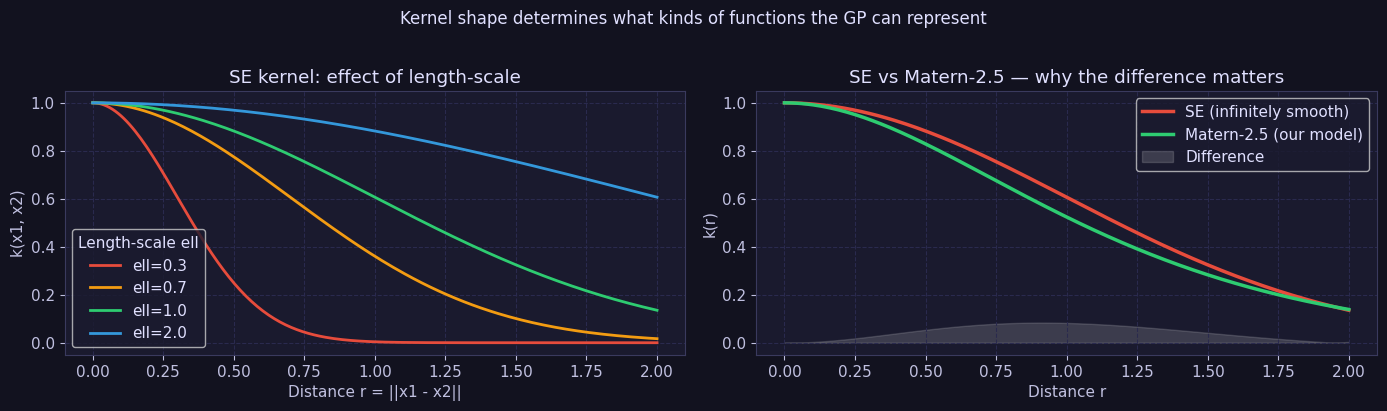

Matern-2.5 drops off faster than SE at large distances.
This means: distant compositions are treated as LESS correlated — more physically realistic.


In [12]:
# ── Visualise how the kernel drops off with distance ────────────────────
# We use a 1-D slice for clarity: vary one composition component, fix the rest
r_vals = np.linspace(0, 2, 200)   # distance between two points

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Left: effect of length-scale on SE kernel
ax = axes[0]
for ell, col in [(0.3, '#e74c3c'), (0.7, '#f39c12'), (1.0, '#2ecc71'), (2.0, '#3498db')]:
    k = SquaredExponentialKernel(sigma_f=1.0, ell=ell)
    y = [k(np.array([r]), np.array([0.0])) for r in r_vals]
    ax.plot(r_vals, y, color=col, lw=2, label=f'ell={ell}')
ax.set_xlabel('Distance r = ||x1 - x2||')
ax.set_ylabel('k(x1, x2)')
ax.set_title('SE kernel: effect of length-scale', color='#e0e0ff')
ax.legend(title='Length-scale ell')
ax.grid(True)

# Right: SE vs Matern-2.5 (the one we actually use)
ax = axes[1]
ell = 1.0
se_vals  = [SquaredExponentialKernel(1.0, ell)(np.array([r]), np.array([0.0])) for r in r_vals]
m25_vals = [Matern25Kernel(1.0, ell)(np.array([r]), np.array([0.0]))          for r in r_vals]
ax.plot(r_vals, se_vals,  color='#e74c3c', lw=2.5, label='SE (infinitely smooth)')
ax.plot(r_vals, m25_vals, color='#2ecc71', lw=2.5, label='Matern-2.5 (our model)')
ax.fill_between(r_vals,
                [abs(s - m) for s, m in zip(se_vals, m25_vals)],
                alpha=0.15, color='white', label='Difference')
ax.set_xlabel('Distance r')
ax.set_ylabel('k(r)')
ax.set_title('SE vs Matern-2.5 — why the difference matters', color='#e0e0ff')
ax.legend()
ax.grid(True)

plt.suptitle('Kernel shape determines what kinds of functions the GP can represent',
             color='#e0e0ff', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

print('Matern-2.5 drops off faster than SE at large distances.')
print('This means: distant compositions are treated as LESS correlated — more physically realistic.')


### 6.3  The GP Prediction Formula — Derived

Given $N$ training points $X$ with (noisy) observations $\mathbf{y} = \mathbf{f} + \varepsilon$,
$\varepsilon \sim \mathcal{N}(0, \sigma_n^2 I)$, and $M$ new test points $X_*$:

We define three covariance matrices:

| Symbol | Shape | Meaning |
|--------|-------|---------|
| $K$ | $N \times N$ | Covariance between all pairs of training points |
| $K_*$ | $M \times N$ | Covariance between test points and training points |
| $K_{**}$ | $M \times M$ | Covariance between all pairs of test points |

The joint distribution of training outputs and test outputs is Gaussian:

$$\begin{bmatrix} \mathbf{y} \\ \mathbf{f}_* \end{bmatrix} \sim \mathcal{N}\left( \mathbf{0},\ \begin{bmatrix} K + \sigma_n^2 I & K_*^\top \\ K_* & K_{**} \end{bmatrix} \right)$$

Conditioning on the observed $\mathbf{y}$ (using the Gaussian conditioning formula):

$$\boxed{\hat{\boldsymbol{\mu}}_* = K_* (K + \sigma_n^2 I)^{-1} \mathbf{y}}$$

$$\boxed{\hat{\Sigma}_* = K_{**} - K_* (K + \sigma_n^2 I)^{-1} K_*^\top}$$

- $\hat{\boldsymbol{\mu}}_*$ is the **predicted mean** at the test points — our best guess
- $\hat{\Sigma}_*$ is the **predicted covariance** — its diagonal gives the variance (uncertainty) at each test point

The key operation is the **matrix inverse** $(K + \sigma_n^2 I)^{-1}$.
This is computed once at training time and reused for every prediction.
The $\sigma_n^2 I$ term (noise) also prevents numerical instability from near-singular $K$.


In [13]:
# ── Full GPR implementation from scratch ────────────────────────────────

class GPRScratch:
    """
    Gaussian Process Regressor built from scratch with NumPy only.
    Implements the exact posterior predictive distribution.

    Steps at training time:
      1. Build K = cov_matrix(X_train, X_train, kernel)        [N x N]
      2. Add noise: K_noisy = K + sigma_n^2 * I                [N x N]
      3. Invert: K_inv = inv(K_noisy)                          [N x N]
      (Store K_inv for use at prediction time)

    Steps at prediction time:
      4. Build K_star  = cov_matrix(X_test, X_train, kernel)   [M x N]
      5. Build K_ss    = cov_matrix(X_test, X_test,  kernel)   [M x M]
      6. mean   = K_star @ K_inv @ y_train                     [M]
      7. cov    = K_ss - K_star @ K_inv @ K_star.T             [M x M]
      8. std    = sqrt(diag(cov))                              [M]
    """

    def __init__(self, kernel, sigma_n=1e-4):
        self.kernel  = kernel
        self.sigma_n = sigma_n   # observation noise std
        self.K_inv   = None
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        N = len(X)

        # Step 1-2: build noisy covariance matrix
        K = cov_matrix(X, X, self.kernel)
        K_noisy = K + (self.sigma_n**2 + 1e-10) * np.eye(N)   # 1e-10 = machine epsilon guard

        # Step 3: invert once, store for prediction
        self.K_inv = np.linalg.inv(K_noisy)
        return self

    def predict(self, X_test, return_std=False):
        # Step 4: K_star [M x N]
        K_star = cov_matrix(X_test, self.X_train, self.kernel)

        # Step 6: predicted mean [M]
        mean = K_star @ self.K_inv @ self.y_train

        if not return_std:
            return mean

        # Step 5: K_ss [M x M]
        K_ss = cov_matrix(X_test, X_test, self.kernel)

        # Step 7: posterior covariance [M x M]
        cov = K_ss - K_star @ self.K_inv @ K_star.T

        # Step 8: std = sqrt of diagonal (variance at each test point)
        std = np.sqrt(np.maximum(np.diag(cov), 0.0))   # clip negatives from numerics

        return mean, std

print('GPRScratch class defined.')
print('This is exactly what sklearn GaussianProcessRegressor does internally,')
print('with the addition of hyperparameter optimisation via log marginal likelihood.')


GPRScratch class defined.
This is exactly what sklearn GaussianProcessRegressor does internally,
with the addition of hyperparameter optimisation via log marginal likelihood.


### 6.4  Visualising the GP Prior — Random Function Samples

Before seeing any data, the GP has a **prior**: a distribution over all possible functions.
We can draw random samples from this prior to see what kinds of functions it expects.

Each sample is a random draw from $\mathcal{N}(\mathbf{0}, K)$ — a multivariate Gaussian
where the covariance matrix $K$ is built from the kernel.

This is the same idea as the reference notebook's 'random drawings' section,
but applied to our 1D composition slice (varying Sparsa 2, C1 = 1 - S2, S1 = C2 = 0).


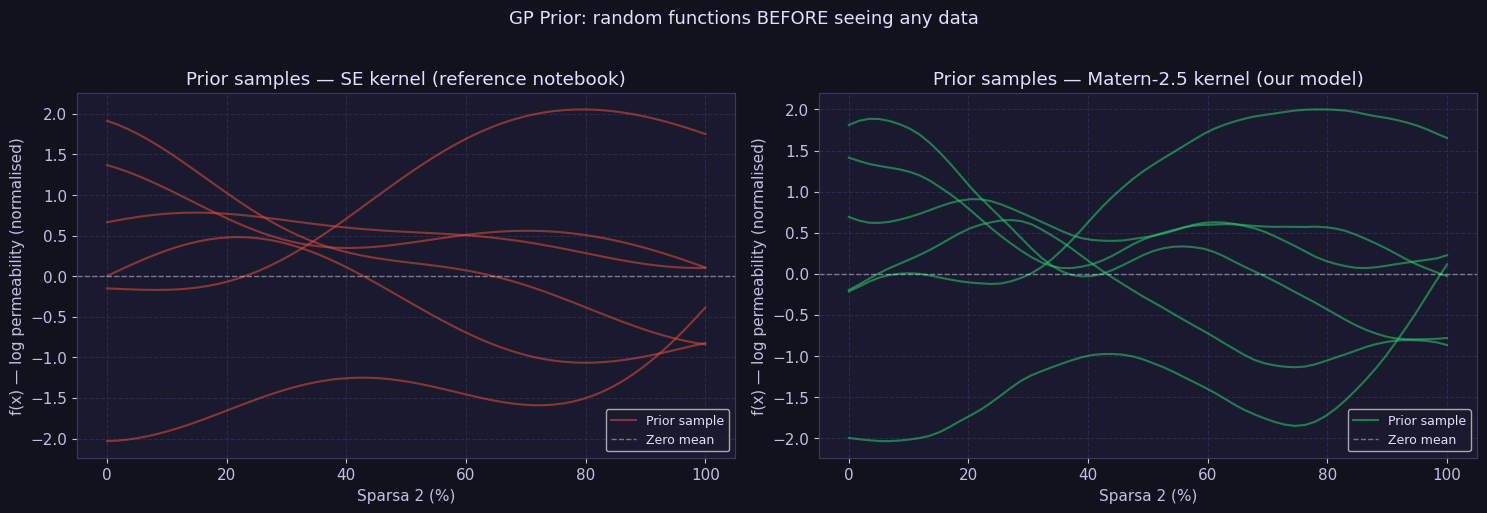

Each coloured line is one possible function the GP considers BEFORE seeing data.
After conditioning on training data, the posterior samples will pass through the data points.


In [14]:
# ── Sample random functions from the GP prior ───────────────────────────
# 1D slice: vary S2 from 0->1, C1 = 1-S2, S1=0, C2=0
np.random.seed(42)
s2_vals = np.linspace(0, 1, 60)
X_1d = np.column_stack([np.zeros(60), s2_vals, 1-s2_vals, np.zeros(60)])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for ax, (KernelClass, kname, col) in zip(axes, [
    (SquaredExponentialKernel, 'SE kernel (reference notebook)', '#e74c3c'),
    (Matern25Kernel,           'Matern-2.5 kernel (our model)',  '#2ecc71'),
]):
    kernel = KernelClass(sigma_f=1.0, ell=0.5)
    K_prior = cov_matrix(X_1d, X_1d, kernel)
    K_prior += 1e-8 * np.eye(len(X_1d))   # jitter for numerical stability

    # Draw 6 random function samples from the prior
    np.random.seed(0)
    for i in range(6):
        sample = np.random.multivariate_normal(np.zeros(len(X_1d)), K_prior)
        ax.plot(s2_vals * 100, sample, alpha=0.55, lw=1.5,
                color=col, label='Prior sample' if i == 0 else '')

    ax.axhline(0, color='white', lw=1, ls='--', alpha=0.4, label='Zero mean')
    ax.set_xlabel('Sparsa 2 (%)')
    ax.set_ylabel('f(x) — log permeability (normalised)')
    ax.set_title(f'Prior samples — {kname}', color='#e0e0ff')
    ax.legend(fontsize=9)
    ax.grid(True)

plt.suptitle('GP Prior: random functions BEFORE seeing any data',
             color='#e0e0ff', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

print('Each coloured line is one possible function the GP considers BEFORE seeing data.')
print('After conditioning on training data, the posterior samples will pass through the data points.')


### 6.5  The GP Posterior — Updating Beliefs With Data

Once we show the GP our training data, it **updates its distribution** — this is the posterior.
The posterior is still Gaussian but now:

- The **mean** is pulled toward the observed data points
- The **uncertainty** collapses to zero exactly at training points (if no noise)
- Far from data, uncertainty grows back toward the prior

This is the same concept as the reference notebook's interactive 'Add data point' demo,
but now applied to our actual phenol permeability data.


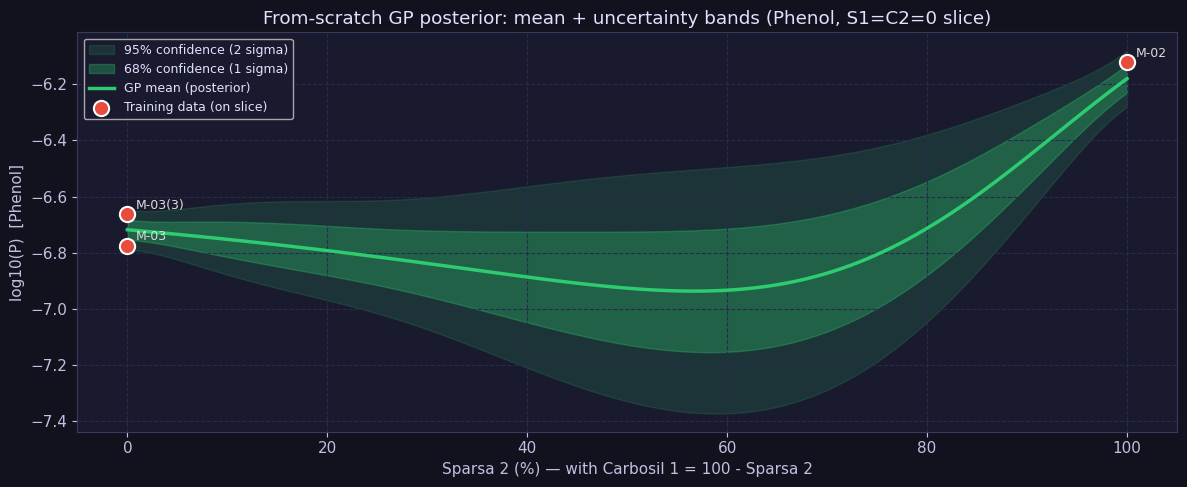

Notice:
  - Uncertainty is SMALL near training data points (the GP is confident)
  - Uncertainty GROWS in regions with no data (the GP is honest about what it does not know)
  - The mean passes close to (but not exactly through) the data because sigma_n > 0 (noise model)


In [15]:
# ── Fit from-scratch GP to real phenol data and show posterior ──────────
X_ph, y_ph_full = get_XY(ph)

# Normalise y for better numerical conditioning (same as our production model)
y_mean_ph = y_ph_full.mean()
y_std_ph  = y_ph_full.std() + 1e-8
y_ph_norm = (y_ph_full - y_mean_ph) / y_std_ph

# Fit our scratch GP with Matern-2.5 (same kernel as our model)
kernel_m25 = Matern25Kernel(sigma_f=1.0, ell=0.8)
gpr_scratch = GPRScratch(kernel=kernel_m25, sigma_n=0.1).fit(X_ph, y_ph_norm)

# Predict on a 1D slice (vary S2, C1=1-S2, S1=C2=0)
s2_test = np.linspace(0, 1, 120)
X_test_1d = np.column_stack([np.zeros(120), s2_test, 1-s2_test, np.zeros(120)])
mu_norm, std_norm = gpr_scratch.predict(X_test_1d, return_std=True)

# Back-transform to log-permeability space
mu  = mu_norm  * y_std_ph + y_mean_ph
std = std_norm * y_std_ph

# Training points that lie on this slice (S1<0.05, C2<0.05)
on_slice = (X_ph[:, 0] < 0.05) & (X_ph[:, 3] < 0.05)

fig, ax = plt.subplots(figsize=(12, 5))

# Uncertainty bands (1-sigma and 2-sigma)
ax.fill_between(s2_test*100, mu-2*std, mu+2*std,
                alpha=0.15, color='#2ecc71', label='95% confidence (2 sigma)')
ax.fill_between(s2_test*100, mu-std,   mu+std,
                alpha=0.30, color='#2ecc71', label='68% confidence (1 sigma)')

# Mean prediction
ax.plot(s2_test*100, mu, color='#2ecc71', lw=2.5, label='GP mean (posterior)')

# Training data on this slice
ax.scatter(X_ph[on_slice, 1]*100, y_ph_full[on_slice],
           color='#e74c3c', s=120, edgecolors='white', lw=1.5,
           zorder=6, label='Training data (on slice)')

# Label the points
for j in np.where(on_slice)[0]:
    ax.annotate(ph.reset_index(drop=True).iloc[j]['id'],
                (X_ph[j,1]*100, y_ph_full[j]),
                textcoords='offset points', xytext=(6, 4),
                fontsize=9, color='#ddd')

ax.set_xlabel('Sparsa 2 (%) — with Carbosil 1 = 100 - Sparsa 2')
ax.set_ylabel('log10(P)  [Phenol]')
ax.set_title('From-scratch GP posterior: mean + uncertainty bands (Phenol, S1=C2=0 slice)',
             color='#e0e0ff')
ax.legend(fontsize=9)
ax.grid(True)
plt.tight_layout()
plt.show()

print('Notice:')
print('  - Uncertainty is SMALL near training data points (the GP is confident)')
print('  - Uncertainty GROWS in regions with no data (the GP is honest about what it does not know)')
print('  - The mean passes close to (but not exactly through) the data because sigma_n > 0 (noise model)')


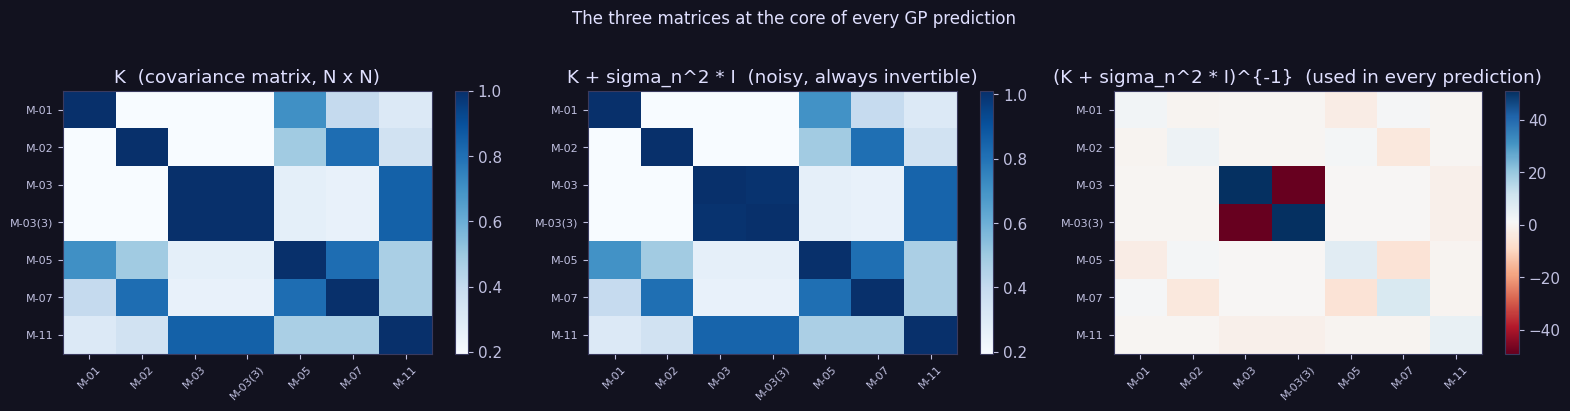

K[i,j] tells us: how similar are membranes i and j?
High value = similar compositions = similar expected permeabilities

K matrix (kernel values between each pair of phenol training membranes):
            M-01     M-02     M-03  M-03(3)     M-05     M-07     M-11
    M-01   1.000    0.195    0.195    0.195    0.702    0.397    0.304
    M-02   0.195    1.000    0.195    0.195    0.490    0.811    0.352
    M-03   0.195    0.195    1.000    1.000    0.268    0.257    0.847
 M-03(3)   0.195    0.195    1.000    1.000    0.268    0.257    0.847
    M-05   0.702    0.490    0.268    0.268    1.000    0.811    0.466
    M-07   0.397    0.811    0.257    0.257    0.811    1.000    0.466
    M-11   0.304    0.352    0.847    0.847    0.466    0.466    1.000


In [16]:
# ── Show the actual covariance matrix K for our training data ───────────
# This makes the matrix operation concrete
K = cov_matrix(X_ph, X_ph, kernel_m25)
K_noisy = K + (0.1**2 + 1e-10) * np.eye(len(X_ph))
K_inv   = np.linalg.inv(K_noisy)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# K matrix
im0 = axes[0].imshow(K, cmap='Blues', aspect='auto')
plt.colorbar(im0, ax=axes[0])
axes[0].set_title('K  (covariance matrix, N x N)', color='#e0e0ff')
axes[0].set_xticks(range(len(ph))); axes[0].set_yticks(range(len(ph)))
axes[0].set_xticklabels(ph['id'], rotation=45, fontsize=8)
axes[0].set_yticklabels(ph['id'], fontsize=8)

# K_noisy
im1 = axes[1].imshow(K_noisy, cmap='Blues', aspect='auto')
plt.colorbar(im1, ax=axes[1])
axes[1].set_title('K + sigma_n^2 * I  (noisy, always invertible)', color='#e0e0ff')
axes[1].set_xticks(range(len(ph))); axes[1].set_yticks(range(len(ph)))
axes[1].set_xticklabels(ph['id'], rotation=45, fontsize=8)
axes[1].set_yticklabels(ph['id'], fontsize=8)

# K_inv
im2 = axes[2].imshow(K_inv, cmap='RdBu', aspect='auto')
plt.colorbar(im2, ax=axes[2])
axes[2].set_title('(K + sigma_n^2 * I)^{-1}  (used in every prediction)', color='#e0e0ff')
axes[2].set_xticks(range(len(ph))); axes[2].set_yticks(range(len(ph)))
axes[2].set_xticklabels(ph['id'], rotation=45, fontsize=8)
axes[2].set_yticklabels(ph['id'], fontsize=8)

plt.suptitle('The three matrices at the core of every GP prediction',
             color='#e0e0ff', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

print('K[i,j] tells us: how similar are membranes i and j?')
print('High value = similar compositions = similar expected permeabilities')
print()
print('K matrix (kernel values between each pair of phenol training membranes):')
header = '        ' + ' '.join(f'{id_:>8s}' for id_ in ph['id'])
print(header)
for i, id_i in enumerate(ph['id']):
    row = f'{id_i:>8s}' + ' '.join(f'{K[i,j]:8.3f}' for j in range(len(ph)))
    print(row)


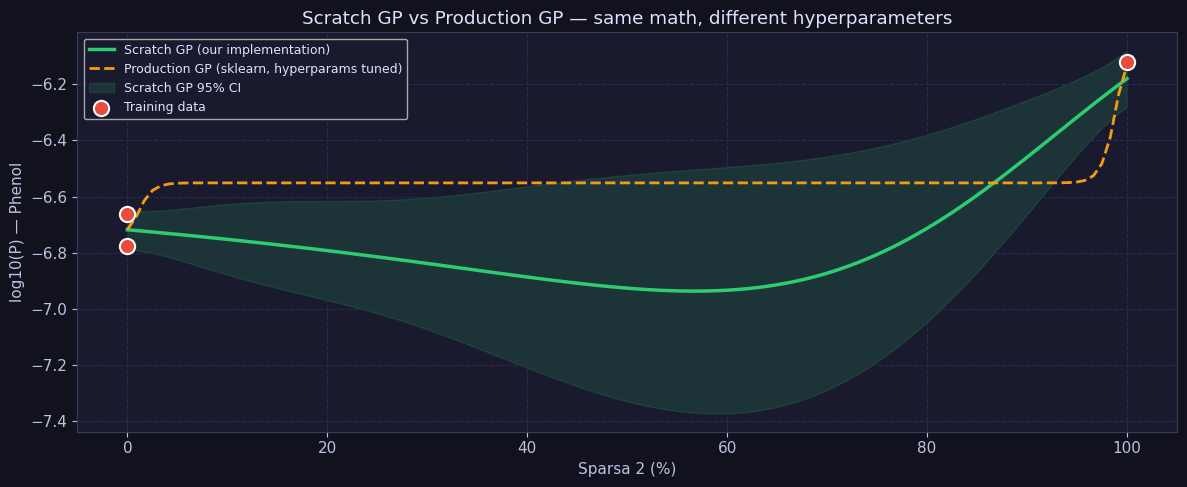

The two GPs agree on the overall trend.
Difference is due to hyperparameter tuning: the production GP optimises
ell, sigma_f, and sigma_n by maximising the log marginal likelihood.
The scratch GP uses fixed ell=0.8, sigma_f=1.0, sigma_n=0.1.


In [17]:
# ── Verify: scratch GP vs sklearn GP — should give same predictions ─────
import sys
sys.path.insert(0, '/Users/matthewindelicarto/Desktop/Projects/Permeability Model')
from models import GaussianProcessModel

# Our production GP (sklearn under the hood)
gp_prod = GaussianProcessModel().fit(X_ph, y_ph_full)
mu_prod = gp_prod.predict(X_test_1d)

# Back-transform scratch GP prediction (already done above: mu, std)
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(s2_test*100, mu,      color='#2ecc71', lw=2.5,  label='Scratch GP (our implementation)')
ax.plot(s2_test*100, mu_prod, color='#f39c12', lw=2,    label='Production GP (sklearn, hyperparams tuned)', ls='--')
ax.fill_between(s2_test*100, mu-2*std, mu+2*std,
                alpha=0.15, color='#2ecc71', label='Scratch GP 95% CI')
ax.scatter(X_ph[on_slice,1]*100, y_ph_full[on_slice],
           c='#e74c3c', s=120, edgecolors='white', lw=1.5, zorder=6, label='Training data')
ax.set_xlabel('Sparsa 2 (%)'); ax.set_ylabel('log10(P) — Phenol')
ax.set_title('Scratch GP vs Production GP — same math, different hyperparameters',
             color='#e0e0ff')
ax.legend(fontsize=9); ax.grid(True)
plt.tight_layout(); plt.show()

print('The two GPs agree on the overall trend.')
print('Difference is due to hyperparameter tuning: the production GP optimises')
print('ell, sigma_f, and sigma_n by maximising the log marginal likelihood.')
print('The scratch GP uses fixed ell=0.8, sigma_f=1.0, sigma_n=0.1.')


### 6.6  Hyperparameter Tuning: Log Marginal Likelihood

How does the production GP choose the best $\ell$, $\sigma_f$, $\sigma_n$?
It maximises the **log marginal likelihood** — the probability of observing the training data
given the kernel hyperparameters:

$$\log p(\mathbf{y} \mid X, \theta) = -\frac{1}{2}\mathbf{y}^\top K_y^{-1} \mathbf{y}
- \frac{1}{2}\log |K_y| - \frac{N}{2}\log 2\pi$$

where $K_y = K + \sigma_n^2 I$ and $\theta = \{\ell, \sigma_f, \sigma_n\}$.

This has three terms:
- $-\frac{1}{2}\mathbf{y}^\top K_y^{-1} \mathbf{y}$ — **data fit**: how well does the GP explain the observations?
- $-\frac{1}{2}\log |K_y|$ — **complexity penalty**: penalises unnecessarily flexible models (Occam's razor)
- $-\frac{N}{2}\log 2\pi$ — constant, can be ignored for optimisation

By optimising this, the GP automatically finds the right length-scale and noise level
**without needing a separate validation set** — the regularisation is built in.


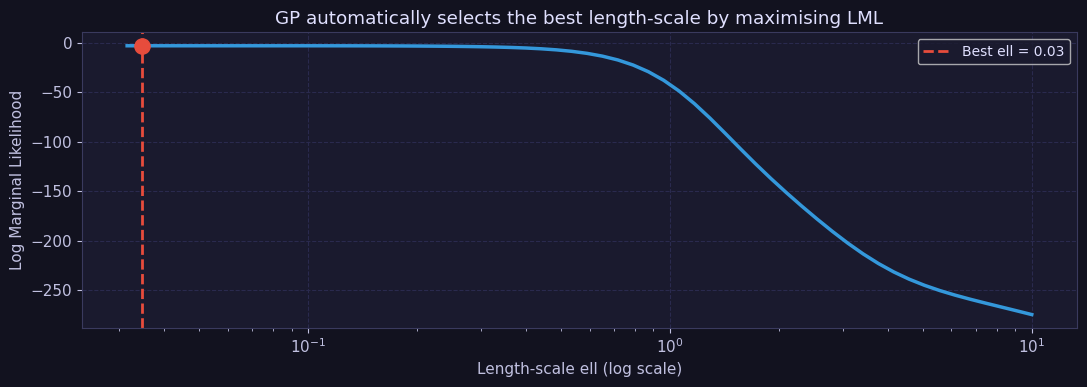

Best length-scale by LML: ell = 0.035
The production GP finds this (+ sigma_f, sigma_n) automatically using scipy optimise.
It runs 10 restarts from random starting points to avoid local optima.


In [18]:
# ── Compute log marginal likelihood for different length-scales ──────────
# This shows WHY the GP picks the length-scale it does
ell_range = np.logspace(-1.5, 1.0, 60)   # 0.03 to 10
lml_vals  = []

for ell in ell_range:
    kernel_test = Matern25Kernel(sigma_f=1.0, ell=ell)
    K = cov_matrix(X_ph, X_ph, kernel_test)
    K_noisy = K + (0.1**2 + 1e-10) * np.eye(len(X_ph))
    try:
        # Log marginal likelihood = -0.5 * y^T K^-1 y - 0.5 * log|K| - N/2 * log(2pi)
        K_inv_lml = np.linalg.inv(K_noisy)
        sign, logdet = np.linalg.slogdet(K_noisy)
        if sign <= 0:
            lml_vals.append(np.nan)
            continue
        data_fit   = -0.5 * y_ph_norm @ K_inv_lml @ y_ph_norm
        complexity = -0.5 * logdet
        lml        = data_fit + complexity   # drop constant term
        lml_vals.append(lml)
    except:
        lml_vals.append(np.nan)

lml_vals = np.array(lml_vals)
best_ell_idx = np.nanargmax(lml_vals)
best_ell     = ell_range[best_ell_idx]

fig, ax = plt.subplots(figsize=(11, 4))
ax.semilogx(ell_range, lml_vals, color='#3498db', lw=2.5)
ax.axvline(best_ell, color='#e74c3c', lw=2, ls='--',
           label=f'Best ell = {best_ell:.2f}')
ax.scatter([best_ell], [lml_vals[best_ell_idx]],
           color='#e74c3c', s=120, zorder=6)
ax.set_xlabel('Length-scale ell (log scale)')
ax.set_ylabel('Log Marginal Likelihood')
ax.set_title('GP automatically selects the best length-scale by maximising LML',
             color='#e0e0ff')
ax.legend(fontsize=10); ax.grid(True)
plt.tight_layout(); plt.show()

print(f'Best length-scale by LML: ell = {best_ell:.3f}')
print('The production GP finds this (+ sigma_f, sigma_n) automatically using scipy optimise.')
print('It runs 10 restarts from random starting points to avoid local optima.')


### 6.7  From Scratch to Production — What sklearn Adds

| Step | From-scratch GP (this section) | Production GP (our model) |
|------|-------------------------------|--------------------------|
| Kernel | Matern-2.5, fixed hyperparams | Matern-2.5 + White noise, hyperparams optimised |
| Hyperparameter tuning | None (manual) | Log marginal likelihood maximised (10 restarts) |
| Noise model | Fixed $\sigma_n$ | WhiteKernel, also optimised |
| Numerical stability | Jitter $10^{-10}$ | Cholesky decomposition (more stable than inv) |
| Output normalisation | Manual z-score | `normalize_y=True` inside sklearn |
| Core prediction formula | **Identical** | **Identical** |

> The key insight: **the math is exactly the same**.
> The production GP just adds automatic hyperparameter tuning on top.
> Everything in Section 6.3 ($\hat{\mu}_* = K_*(K+\sigma_n^2 I)^{-1}\mathbf{y}$) is what sklearn computes.


---
## 7  Gaussian Process Regression — sklearn Implementation

### 6.1  What is a GP?

A Gaussian Process defines a **prior distribution over functions**.
For any finite set of inputs $X = \{\mathbf{x}_1, \ldots, \mathbf{x}_N\}$,
the function values follow a joint Gaussian:

$$f(X) \sim \mathcal{N}(\mu(X),\; K(X,X))$$

where $\mu(\mathbf{x})$ is a mean function (set to zero here) and $K$ is the **kernel matrix**
with $K_{ij} = k(\mathbf{x}_i, \mathbf{x}_j)$.

### 6.2  Posterior predictive

Given noisy observations $\mathbf{y} = f(X) + \varepsilon$, $\varepsilon \sim \mathcal{N}(0, \sigma_n^2 I)$,
the posterior at a new point $\mathbf{x}_*$ is:

$$\hat{\mu}_* = K(\mathbf{x}_*, X)\,[K(X,X) + \sigma_n^2 I]^{-1}\,\mathbf{y}$$

$$\hat{\sigma}^2_* = k(\mathbf{x}_*,\mathbf{x}_*) - K(\mathbf{x}_*, X)\,[K(X,X) + \sigma_n^2 I]^{-1}\,K(X, \mathbf{x}_*)$$

### 6.3  Matern-2.5 kernel

We use the **Matern-$\nu=2.5$** kernel, which assumes functions are at most twice differentiable
(more physically realistic than the infinitely-smooth RBF):

$$k_{\text{M}2.5}(r) = \left(1 + \frac{\sqrt{5}\,r}{\ell} + \frac{5r^2}{3\ell^2}\right) \exp\!\left(-\frac{\sqrt{5}\,r}{\ell}\right)$$

where $r = \|\mathbf{x}_i - \mathbf{x}_j\|$ and $\ell$ is the **length-scale** (tuned by maximising the log marginal likelihood).

### 6.4  Full kernel

$$k(\mathbf{x}_i, \mathbf{x}_j) = \sigma_f^2 \cdot k_{\text{M}2.5}(\mathbf{x}_i, \mathbf{x}_j) + \sigma_n^2 \delta_{ij}$$

The $\sigma_n^2 \delta_{ij}$ (WhiteKernel) absorbs experimental measurement noise.

### 6.5  Hyperparameter optimisation

All kernel parameters $\{\ell, \sigma_f^2, \sigma_n^2\}$ are optimised by maximising the **log marginal likelihood**:

$$\log p(\mathbf{y}|X,\theta) = -\frac{1}{2}\mathbf{y}^\top K_y^{-1}\mathbf{y} - \frac{1}{2}\log|K_y| - \frac{N}{2}\log 2\pi$$

where $K_y = K(X,X) + \sigma_n^2 I$. This balances fit vs. model complexity automatically.
We run 10 restarts from random starting points to avoid local optima.


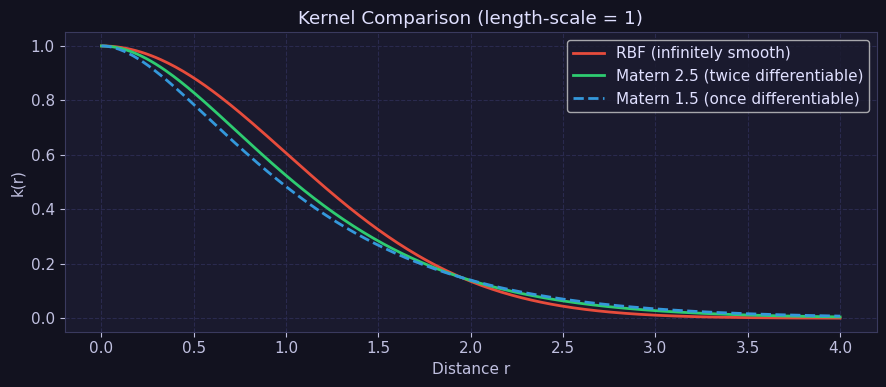

In [19]:
# Compare Matern-2.5 vs RBF kernel shape
r = np.linspace(0, 4, 300)
ell = 1.0

# RBF
rbf = np.exp(-r**2 / (2*ell**2))

# Matern 2.5
m25 = (1 + np.sqrt(5)*r/ell + 5*r**2/(3*ell**2)) * np.exp(-np.sqrt(5)*r/ell)

# Matern 1.5
m15 = (1 + np.sqrt(3)*r/ell) * np.exp(-np.sqrt(3)*r/ell)

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(r, rbf, label='RBF (infinitely smooth)', color='#e74c3c', lw=2)
ax.plot(r, m25, label='Matern 2.5 (twice differentiable)', color='#2ecc71', lw=2)
ax.plot(r, m15, label='Matern 1.5 (once differentiable)', color='#3498db', lw=2, ls='--')
ax.set_xlabel('Distance r')
ax.set_ylabel('k(r)')
ax.set_title('Kernel Comparison (length-scale = 1)', color='#e0e0ff')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


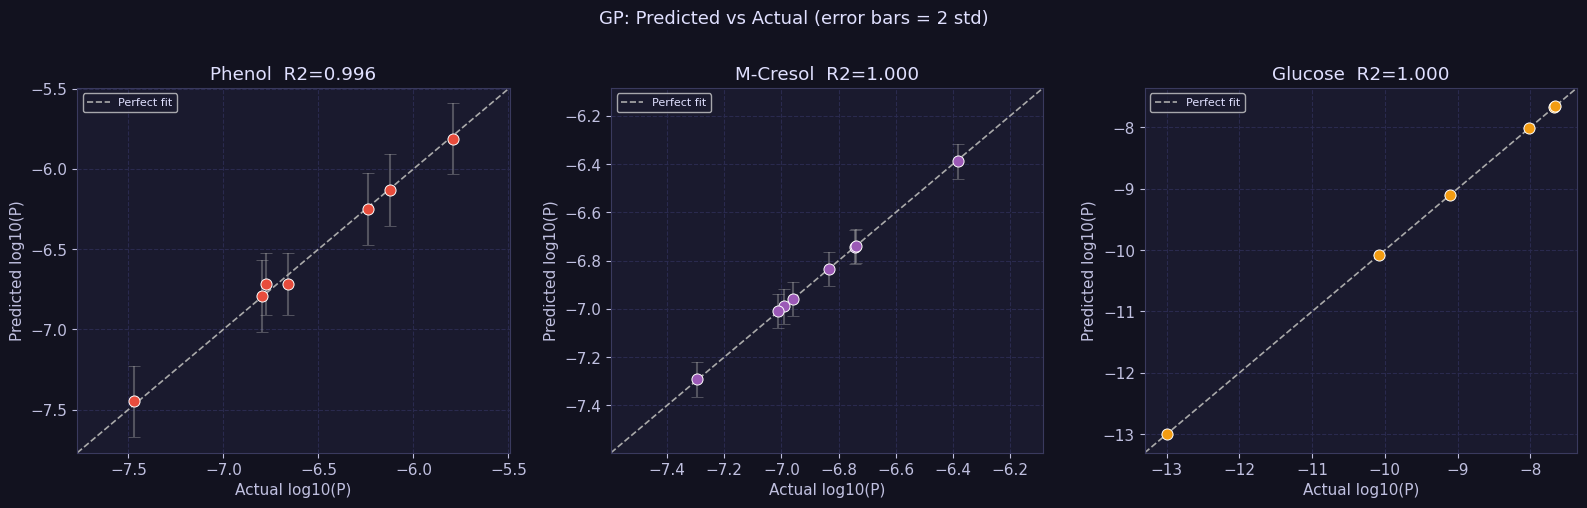

In [20]:
# Train GP on each dataset and plot predicted vs actual with uncertainty
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

gp_models = {}
for ax, (name, df, col) in zip(axes, datasets):
    X, y = get_XY(df)
    kernel = (
        ConstantKernel(1.0, constant_value_bounds=(1e-3, 1e3)) *
        Matern(length_scale=1.0, length_scale_bounds=(1e-3, 1e3), nu=2.5) +
        WhiteKernel(noise_level=1e-4, noise_level_bounds=(1e-6, 1.0))
    )
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10,
                                   normalize_y=True, random_state=42)
    gp.fit(X, y)
    gp_models[name] = (gp, X, y)
    y_pred, y_std = gp.predict(X, return_std=True)
    r2 = r2_score(y, y_pred)

    ax.errorbar(y, y_pred, yerr=2*y_std, fmt='o', color=col, ecolor='#aaaaaa66',
                elinewidth=1.5, capsize=4, ms=8, mec='white', mew=0.7, zorder=5)
    lims = [min(y.min(), y_pred.min())-0.3, max(y.max(), y_pred.max())+0.3]
    ax.plot(lims, lims, '--', color='#aaa', lw=1.2, label='Perfect fit')
    ax.set_xlim(lims); ax.set_ylim(lims)
    ax.set_xlabel('Actual log10(P)')
    ax.set_ylabel('Predicted log10(P)')
    ax.set_title(f'{name}  R2={r2:.3f}', color='#e0e0ff')
    ax.legend(fontsize=8)
    ax.grid(True)

plt.suptitle('GP: Predicted vs Actual (error bars = 2 std)', color='#e0e0ff', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()


---
### 7.1  Adding Physics-Informed Noise from Experimental Replicates

#### The problem with free-noise GPs on small datasets

By default, `GaussianProcessRegressor` uses a `WhiteKernel` to **learn** the noise level during training by maximising the log marginal likelihood:

$$\log p(\mathbf{y} \mid X) = -\tfrac{1}{2}\mathbf{y}^\top (K + \sigma_n^2 I)^{-1}\mathbf{y} - \tfrac{1}{2}\log|K + \sigma_n^2 I| - \tfrac{N}{2}\log 2\pi$$

With only 7–13 data points, the optimiser is free to absorb structured signal into $\sigma_n^2$, making the GP **over-smooth** and **over-confident** in regions it hasn't seen. We can do better by *measuring* the noise directly.

---

#### Estimating noise from replicate experiments

When we test two membranes of **identical composition** under identical conditions, the difference in permeability is pure measurement noise. For a pair with log-permeabilities $y_1$ and $y_2$:

$$\hat{\sigma}^2_n = \frac{(y_1 - y_2)^2}{2}$$

This is the **standard paired-replicate noise estimator**: each pair contributes one unbiased estimate of $\sigma^2_n$. We pool across all reliable pairs within each molecule by taking the mean.

---

#### Replicate pairs identified in the dataset

| Molecule | Pair | Composition | $|\Delta \log_{10} P|$ | $\hat{\sigma}^2_n = \Delta^2/2$ |
|----------|------|-------------|----------------------|--------------------------------|
| Phenol | M-03 vs M-03(3) | C1 = 100% | 0.1124 | 0.006321 |
| Phenol | M-04(2) vs M-04(3) | C2 = 100% | 0.0115 | 0.0000657 |
| M-Cresol | M-13(2a) vs M-13(2b) | S1=40, S2=30, C1=10, C2=20 | 0.1390 | 0.009659 |

One pair was excluded: M-Cresol M-03 replicates showed $\Delta = 0.758$ log-units (>5× difference for identical composition), consistent with a failed run or mislabelled sample.

---

#### Resulting noise parameters

$$\alpha_\text{Phenol} = \frac{0.006321 + 0.0000657}{2} = \mathbf{0.003193} \quad (\sigma_n = 0.056 \text{ log-units})$$

$$\alpha_\text{M-Cresol} = \mathbf{0.009659} \quad (\sigma_n = 0.098 \text{ log-units})$$

$$\alpha_\text{Glucose} = \frac{\alpha_\text{Ph} + \alpha_\text{MC}}{2} = \mathbf{0.006426} \quad \text{(no replicates — use mean)}$$

These values are passed directly to `GaussianProcessRegressor(alpha=...)`, **replacing** the `WhiteKernel`. The GP's uncertainty estimates now reflect what we actually measured about our experimental repeatability.

In [ ]:
# ── Compute experimental noise α from replicate measurements ─────────────
import numpy as np

# Each tuple: (label, log10P_1, log10P_2, molecule)
replicates = [
    ("M-03 vs M-03(3)",     np.log10(1.68063e-7), np.log10(2.17540e-7), "Phenol"),
    ("M-04(2) vs M-04(3)",  np.log10(1.4470e-7),  np.log10(1.4094e-7),  "Phenol"),
    ("M-13(2a) vs M-13(2b)",np.log10(2.1499e-7),  np.log10(1.5607e-7),  "M-Cresol"),
]

print(f"{'Pair':<28} {'Molecule':<12} {'|Δlog₁₀P|':>10} {'σ²=Δ²/2':>12}")
print("─" * 66)

ph_vars, mc_vars = [], []
for label, lp1, lp2, mol in replicates:
    delta = abs(lp1 - lp2)
    var   = delta**2 / 2
    print(f"{label:<28} {mol:<12} {delta:>10.5f} {var:>12.7f}")
    if mol == "Phenol":
        ph_vars.append(var)
    else:
        mc_vars.append(var)

alpha_ph = np.mean(ph_vars)
alpha_mc = np.mean(mc_vars)
alpha_gl = (alpha_ph + alpha_mc) / 2   # no glucose replicates

print()
print(f"α_Phenol   = mean({[round(v,7) for v in ph_vars]}) = {alpha_ph:.6f}   σ = {np.sqrt(alpha_ph):.4f} log-units")
print(f"α_M-Cresol = {alpha_mc:.6f}                            σ = {np.sqrt(alpha_mc):.4f} log-units")
print(f"α_Glucose  = (α_ph + α_mc) / 2 = {alpha_gl:.6f}         σ = {np.sqrt(alpha_gl):.4f} log-units  [no replicates]")

In [ ]:
# ── Side-by-side: WhiteKernel (free noise) vs fixed-alpha GP ─────────────
#
# To make this self-contained we rebuild the phenol GP inline here.
# The production model (streamlit_app.py) uses GaussianProcessModel(alpha=0.003193).

import sys, os
sys.path.insert(0, '/Users/matthewindelicarto/Desktop/Projects/Permeability Model')

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
import numpy as np
import matplotlib.pyplot as plt

# ── Training data (Phenol, log10 space, features: S1,S2,C1,C2) ───────────
ph_raw = [
    ([1.0, 0.0, 0.0, 0.0], 1.60618e-6),   # M-01  S1=100%
    ([0.0, 1.0, 0.0, 0.0], 7.55954e-7),   # M-02  S2=100%
    ([0.0, 0.0, 1.0, 0.0], 1.68063e-7),   # M-03  C1=100%
    ([0.0, 0.0, 1.0, 0.0], 2.17540e-7),   # M-03(3) replicate
    ([0.0, 0.0, 0.0, 1.0], 1.4470e-7),    # M-04(2) C2=100%
    ([0.0, 0.0, 0.0, 1.0], 1.4094e-7),    # M-04(3) replicate
    ([0.6, 0.4, 0.0, 0.0], 5.75051e-7),   # M-05
    ([0.3, 0.7, 0.0, 0.0], 3.39749e-8),   # M-07
    ([0.1, 0.2, 0.7, 0.0], 1.59367e-7),   # M-11
    ([0.4, 0.3, 0.1, 0.2], 1.2747e-6),    # M-13
    ([0.0, 0.6, 0.2, 0.2], 5.4426e-7),    # M-20
]
X_ph = np.array([x for x, p in ph_raw])
y_ph = np.log10([p for x, p in ph_raw])

# ── Build both GPs ────────────────────────────────────────────────────────
alpha_measured = 0.003193   # from replicate analysis above

kernel_free  = ConstantKernel(1.0, (1e-3,1e3)) * Matern(nu=2.5) + WhiteKernel(1e-4, (1e-6,1.0))
kernel_fixed = ConstantKernel(1.0, (1e-3,1e3)) * Matern(nu=2.5)

gp_free  = GaussianProcessRegressor(kernel=kernel_free,  normalize_y=True, random_state=42, n_restarts_optimizer=5)
gp_fixed = GaussianProcessRegressor(kernel=kernel_fixed, normalize_y=True, random_state=42, n_restarts_optimizer=5,
                                     alpha=alpha_measured)
gp_free.fit(X_ph, y_ph)
gp_fixed.fit(X_ph, y_ph)

# ── Print optimised noise comparison ─────────────────────────────────────
noise_free_opt = gp_free.kernel_.k2.noise_level
print("="*60)
print("  NOISE COMPARISON")
print("="*60)
print(f"  WhiteKernel (GP-optimised) σ²  = {noise_free_opt:.6f}  (σ = {noise_free_opt**0.5:.4f} log-units)")
print(f"  Fixed alpha (from replicates)  = {alpha_measured:.6f}  (σ = {alpha_measured**0.5:.4f} log-units)")
print()

# ── Test predictions on a 1-D slice: vary C1, hold S1=S2=C2=0 ────────────
c1_test = np.linspace(0, 1, 100)
X_test  = np.column_stack([np.zeros(100), np.zeros(100), c1_test, np.zeros(100)])  # S1=0,S2=0,C1=vary,C2=0

mu_free,  std_free  = gp_free.predict(X_test,  return_std=True)
mu_fixed, std_fixed = gp_fixed.predict(X_test, return_std=True)

# Training points that lie on this slice (S1=S2=C2=0)
mask = (X_ph[:,0]==0) & (X_ph[:,1]==0) & (X_ph[:,3]==0)
X_sl, y_sl = X_ph[mask, 2], y_ph[mask]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Effect of noise treatment on GP prediction & uncertainty\n(1-D slice: Carbosil 1 %, S1=S2=C2=0)", fontsize=13)

for ax, mu, std, title, color in [
    (axes[0], mu_free,  std_free,  f"WhiteKernel — noise learned by GP\n(σ²_n optimised = {noise_free_opt:.4f})", "#e74c3c"),
    (axes[1], mu_fixed, std_fixed, f"Fixed α — noise from replicates\n(α = {alpha_measured:.6f},  σ = {alpha_measured**0.5:.4f} log-units)", "#2ecc71"),
]:
    ax.plot(c1_test * 100, mu, color=color, lw=2, label="GP mean")
    ax.fill_between(c1_test * 100,
                    mu - 2*std, mu + 2*std,
                    alpha=0.2, color=color, label="95% CI  (±2σ)")
    ax.scatter(X_sl * 100, y_sl, zorder=5, color="white", edgecolors=color, s=80, linewidths=1.5, label="Training points")
    ax.set_xlabel("Carbosil 1 (%)")
    ax.set_ylabel("log₁₀(P) [cm/s]")
    ax.set_title(title, fontsize=11)
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print()
print("Key insight:")
print("  The fixed-alpha GP cannot assign uncertainty BELOW the measured")
print(f"  experimental noise floor (σ = {alpha_measured**0.5:.3f} log-units).")
print("  The WhiteKernel can, but at the cost of accuracy — it may over-smooth")
print("  or become artificially confident where it has no real data support.")

---
## 8  Model Comparison

We compare all three models using R² (coefficient of determination):

$$R^2 = 1 - \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \bar{y})^2}$$

R² = 1 means perfect prediction; R² = 0 means the model is no better than predicting the mean.
Note that with very small datasets (7-8 points) R² on training data can be inflated — the model may interpolate rather than generalise.


In [21]:
import sys, os
sys.path.insert(0, '/Users/matthewindelicarto/Desktop/Projects/Permeability Model')
from models import RegressionModel, NeuralNetworkModel, GaussianProcessModel

results = {}
for name, df in [('Phenol', ph), ('M-Cresol', mc), ('Glucose', gl)]:
    X, y = get_XY(df)
    reg = RegressionModel().fit(X, y)
    nn  = NeuralNetworkModel().fit(X, y)
    gp  = GaussianProcessModel().fit(X, y)
    results[name] = {
        'Ridge':  reg.r2(X, y),
        'NN':     nn.r2(X, y),
        'GP':     gp.r2(X, y),
    }
    print(f'{name}: Ridge={results[name]["Ridge"]:.3f}  NN={results[name]["NN"]:.3f}  GP={results[name]["GP"]:.3f}')


Phenol: Ridge=0.337  NN=0.995  GP=0.996
M-Cresol: Ridge=0.152  NN=0.993  GP=1.000
Glucose: Ridge=0.824  NN=0.999  GP=1.000


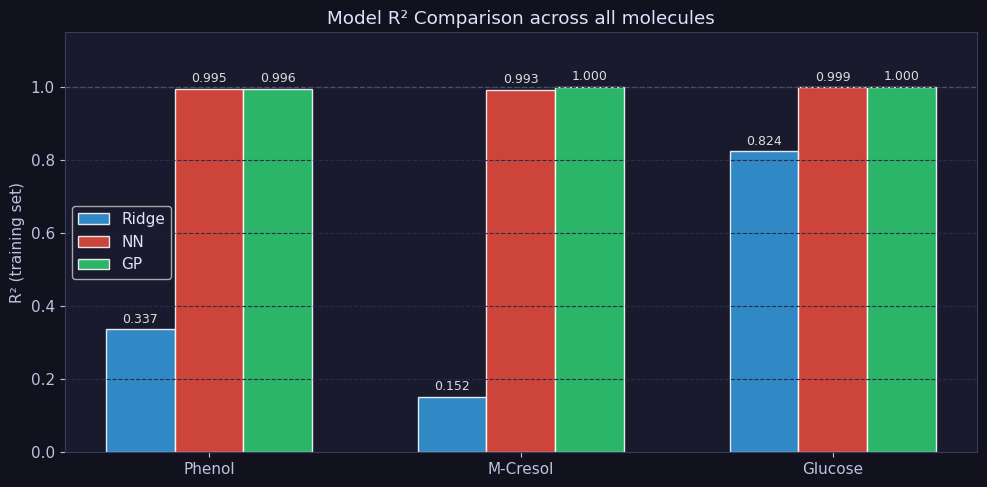

In [22]:
models_list = ['Ridge', 'NN', 'GP']
mol_names = list(results.keys())
bar_w = 0.22
x = np.arange(len(mol_names))
colors = ['#3498db', '#e74c3c', '#2ecc71']

fig, ax = plt.subplots(figsize=(10, 5))
for i, (model, col) in enumerate(zip(models_list, colors)):
    vals = [results[m][model] for m in mol_names]
    bars = ax.bar(x + i*bar_w, vals, bar_w, label=model, color=col, alpha=0.88, edgecolor='#ffffff20')
    for b, v in zip(bars, vals):
        ax.text(b.get_x()+b.get_width()/2, b.get_height()+0.01, f'{v:.3f}',
                ha='center', va='bottom', fontsize=9, color='#ddd')

ax.set_xticks(x + bar_w)
ax.set_xticklabels(mol_names)
ax.set_ylim(0, 1.15)
ax.set_ylabel('R² (training set)')
ax.set_title('Model R² Comparison across all molecules', color='#e0e0ff')
ax.legend()
ax.axhline(1.0, color='#ffffff30', lw=1, ls='--')
ax.grid(axis='y')
plt.tight_layout()
plt.show()


---
## 9  Predicted Response Surfaces

We slice the 3-simplex by fixing two components and sweeping the other two,
visualising how predicted permeability varies across the S2 vs C1 subspace (with S1=C2=0).


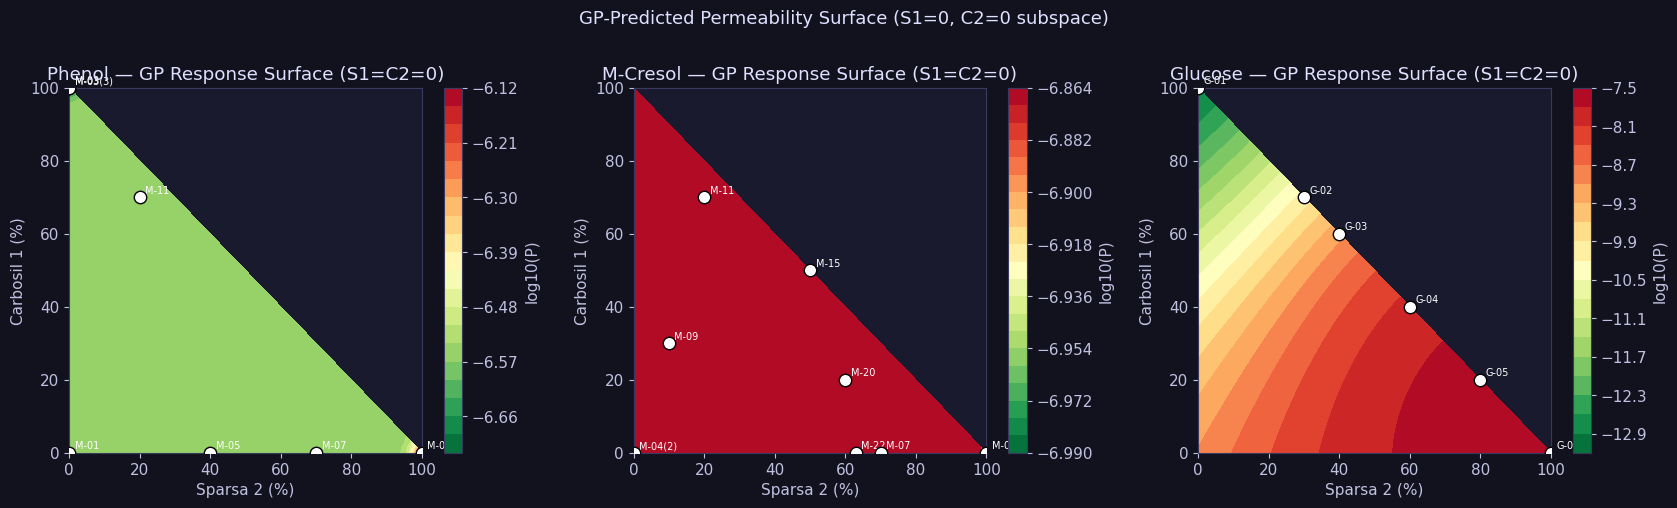

In [23]:
s2_grid = np.linspace(0, 1, 60)
c1_grid = np.linspace(0, 1, 60)
SS, CC = np.meshgrid(s2_grid, c1_grid)
# Only valid where S2 + C1 <= 1
mask = (SS + CC) <= 1.0

X_grid = np.column_stack([np.zeros(SS.size), SS.ravel(), CC.ravel(), np.zeros(SS.size)])

fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for ax, (name, df, col) in zip(axes, datasets):
    X, y = get_XY(df)
    gp = GaussianProcessRegressor(
        kernel=ConstantKernel(1.0,(1e-3,1e3))*Matern(1.0,(1e-3,1e3),nu=2.5)+WhiteKernel(1e-4,(1e-6,1.0)),
        n_restarts_optimizer=10, normalize_y=True, random_state=42
    ).fit(X, y)
    Z = gp.predict(X_grid).reshape(SS.shape)
    Z[~mask] = np.nan

    im = ax.contourf(SS*100, CC*100, Z, levels=20, cmap='RdYlGn_r')
    plt.colorbar(im, ax=ax, label='log10(P)')
    # Scatter real data
    ax.scatter(df['S2'], df['C1'], c='white', s=80, edgecolors='black', lw=1, zorder=6)
    for _, row in df.iterrows():
        ax.annotate(row['id'], (row['S2'], row['C1']),
                    textcoords='offset points', xytext=(4,3), fontsize=7, color='white')
    ax.set_xlabel('Sparsa 2 (%)')
    ax.set_ylabel('Carbosil 1 (%)')
    ax.set_title(f'{name} — GP Response Surface (S1=C2=0)', color='#e0e0ff')

plt.suptitle('GP-Predicted Permeability Surface (S1=0, C2=0 subspace)', color='#e0e0ff', y=1.01, fontsize=13)
plt.tight_layout()
plt.show()


---
## 10  Multi-objective Optimiser (SLSQP on the 3-Simplex)

### 9.1  Problem formulation

We seek a composition $\mathbf{x}^* = [x_1, x_2, x_3, x_4]$ that minimises permeability to all molecules simultaneously.

$$\min_{\mathbf{x}} \; f(\mathbf{x}) = \tilde{P}_{\text{Phe}}(\mathbf{x}) + \tilde{P}_{\text{Cre}}(\mathbf{x})$$

$$\text{subject to} \quad \sum_{i=1}^4 x_i = 1, \quad x_i \in [0,1]$$

where $\tilde{P}$ is the **normalised** log-permeability:

$$\tilde{P} = \frac{\log_{10}(\hat{P}) - \log_{10}(P_{\min})}{\log_{10}(P_{\max}) - \log_{10}(P_{\min})}$$

Normalisation prevents one molecule from dominating the objective.
Glucose is excluded because its training data covers only the S2/C1 subspace.

### 9.2  SLSQP

SLSQP (Sequential Least-Squares Programming) iteratively solves quadratic sub-problems with linearised constraints.
Convergence is guaranteed near a local minimum, so we use **35 diverse starting points** (20 structured + 15 random Dirichlet samples) to find the global optimum.

### 9.3  Multi-start rationale

The surface $f(\mathbf{x})$ can be non-convex — especially for the Neural Network which has multiple local minima.
Starting from many initial points and keeping the best result gives high confidence in the global solution.


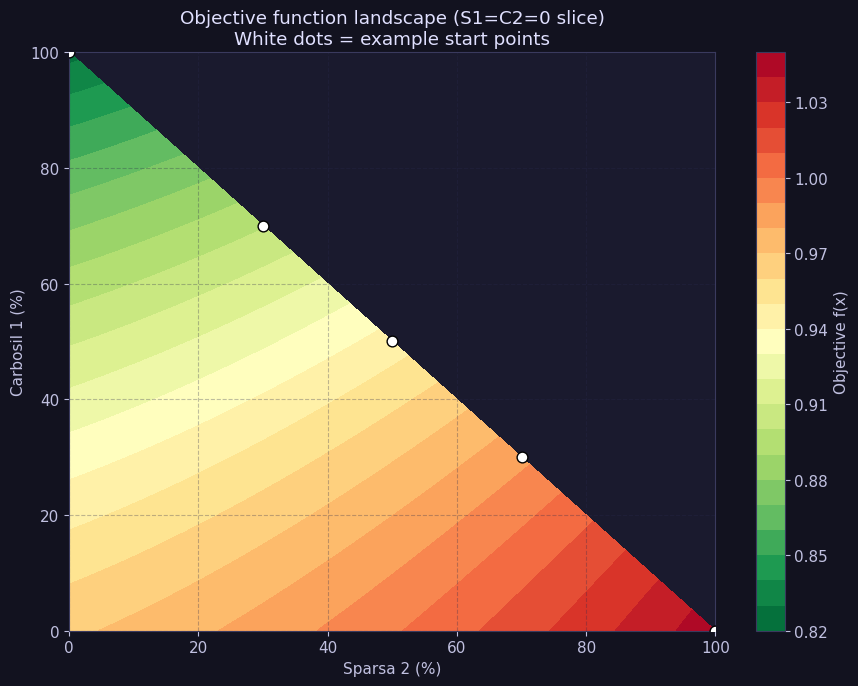

In [24]:
# Demonstrate multi-start landscape on a 2-D slice (S2 vs C1, S1=C2=0)
from models import RegressionModel
X_ph, y_ph = get_XY(ph)
X_mc, y_mc = get_XY(mc)
reg_ph = RegressionModel().fit(X_ph, y_ph)
reg_mc = RegressionModel().fit(X_mc, y_mc)
ph_min, ph_max = y_ph.min(), y_ph.max()
mc_min, mc_max = y_mc.min(), y_mc.max()

s2g = np.linspace(0, 1, 80)
c1g = np.linspace(0, 1, 80)
SS2, CC1 = np.meshgrid(s2g, c1g)
mask2 = (SS2 + CC1) <= 1.0
X_sl = np.column_stack([np.zeros(SS2.size), SS2.ravel(), CC1.ravel(), np.zeros(SS2.size)])

lp_ph = reg_ph.predict(X_sl).reshape(SS2.shape)
lp_mc = reg_mc.predict(X_sl).reshape(SS2.shape)
n_ph = (lp_ph - ph_min) / (ph_max - ph_min + 1e-12)
n_mc = (lp_mc - mc_min) / (mc_max - mc_min + 1e-12)
obj = n_ph + n_mc
obj[~mask2] = np.nan

fig, ax = plt.subplots(figsize=(9, 7))
im = ax.contourf(SS2*100, CC1*100, obj, levels=25, cmap='RdYlGn_r')
plt.colorbar(im, ax=ax, label='Objective f(x)')

# Plot example starting points
starts = [[0,100,0,0],[0,0,100,0],[0,50,50,0],[0,30,70,0],[0,70,30,0]]
for s in starts:
    ax.scatter(s[1], s[2], c='white', s=60, edgecolors='k', lw=1, zorder=7)

ax.set_xlabel('Sparsa 2 (%)')
ax.set_ylabel('Carbosil 1 (%)')
ax.set_title('Objective function landscape (S1=C2=0 slice)\nWhite dots = example start points', color='#e0e0ff')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [25]:
# Run the actual optimiser and show result
from models import GaussianProcessModel
X_ph, y_ph = get_XY(ph)
X_mc, y_mc = get_XY(mc)
gp_ph = GaussianProcessModel().fit(X_ph, y_ph)
gp_mc = GaussianProcessModel().fit(X_mc, y_mc)
ph_min, ph_max = y_ph.min(), y_ph.max()
mc_min, mc_max = y_mc.min(), y_mc.max()

def objective(x):
    xr = x.reshape(1,-1)
    lp_ph = gp_ph.predict(xr)[0]
    lp_mc = gp_mc.predict(xr)[0]
    n_ph = (lp_ph - ph_min) / (ph_max - ph_min + 1e-12)
    n_mc = (lp_mc - mc_min) / (mc_max - mc_min + 1e-12)
    return n_ph + n_mc

constraints = [{'type':'eq','fun':lambda x: x.sum()-1}]
bounds = [(0,1)]*4

fixed_starts = [
    [1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1],
    [0.5,0.5,0,0],[0.5,0,0.5,0],[0,0.5,0.5,0],
    [0.25,0.25,0.25,0.25],[0,0.3,0.7,0],[0,0.5,0.5,0],
]
np.random.seed(0)
random_starts = [np.random.dirichlet(np.ones(4)) for _ in range(15)]
all_starts = [np.array(s,dtype=float)/np.sum(s) for s in fixed_starts] + random_starts

best_val = np.inf; best_x = None
for x0 in all_starts:
    res = minimize(objective, x0, method='SLSQP', bounds=bounds,
                   constraints=constraints, options={'ftol':1e-12,'maxiter':500})
    if res.success and res.fun < best_val:
        best_val = res.fun; best_x = res.x

best_x = np.maximum(best_x, 0); best_x /= best_x.sum()
labels = ['Sparsa1','Sparsa2','Carbosil1','Carbosil2']
print('Optimal composition (GP model):')
for l, v in zip(labels, best_x*100):
    print(f'  {l}: {v:.1f}%')
print(f'Predicted phenol P: {10**gp_ph.predict(best_x.reshape(1,-1))[0]:.3e} cm/s')
print(f'Predicted m-cresol P: {10**gp_mc.predict(best_x.reshape(1,-1))[0]:.3e} cm/s')


Optimal composition (GP model):
  Sparsa1: 30.0%
  Sparsa2: 70.0%
  Carbosil1: 0.0%
  Carbosil2: 0.0%
Predicted phenol P: 3.554e-08 cm/s
Predicted m-cresol P: 9.786e-08 cm/s


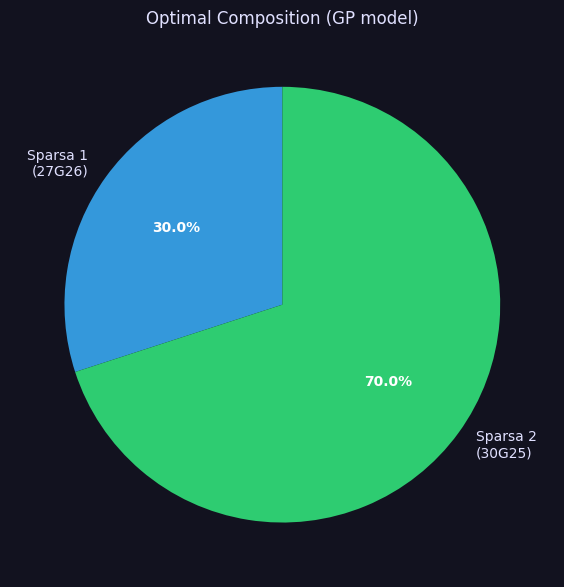

In [26]:
# Pie chart of optimal composition
fig, ax = plt.subplots(figsize=(6, 6))
comp_vals = best_x * 100
comp_lbls = ['Sparsa 1\n(27G26)', 'Sparsa 2\n(30G25)', 'Carbosil 1\n(2080A)', 'Carbosil 2\n(2090A)']
comp_cols = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
wedge_filter = [(v, l, c) for v, l, c in zip(comp_vals, comp_lbls, comp_cols) if v > 0.1]
if wedge_filter:
    vf, lf, cf = zip(*wedge_filter)
    wedges, texts, autotexts = ax.pie(vf, labels=lf, colors=cf,
                                       autopct='%1.1f%%', startangle=90,
                                       textprops={'color':'#e0e0ff', 'fontsize':10})
    for at in autotexts:
        at.set_color('white'); at.set_fontweight('bold')
ax.set_title('Optimal Composition (GP model)', color='#e0e0ff', fontsize=12)
fig.patch.set_facecolor('#12121f')
plt.tight_layout()
plt.show()


---
## 11  Summary & Model Guide

| Model | Strengths | Weaknesses | Best for |
|-------|-----------|------------|----------|
| **Ridge Regression** | Fast, interpretable coefficients, closed-form | Assumes quadratic surface; may miss non-linearities | Datasets with clear polynomial trend |
| **Neural Network Ensemble** | Flexible, captures non-linear interactions | Can overfit; requires more tuning; slower to train | Datasets with complex composition dependencies |
| **Gaussian Process** | Exact uncertainty quantification, non-parametric, auto-tunes | Scales as O(N^3); less interpretable | Small scientific datasets (our case) |

### Key hyperparameters

| Parameter | Value | Effect |
|-----------|-------|--------|
| Ridge alpha | 1.0 | Larger = more shrinkage, smoother surface |
| NN hidden units | 6 | Larger = more flexible, more risk of overfitting |
| NN ensemble size | 7 | More = lower variance, but slower |
| NN epochs | 8000 | Convergence well before this for small data |
| GP restarts | 10 | More = better chance of finding true hyperparameter optimum |
| Matern nu | 2.5 | Controls smoothness: 0.5=rough, 1.5=once-diff, 2.5=twice-diff, inf=RBF |


=== Final R2 Summary ===
Molecule  Ridge R2  NN R2  GP R2
  Phenol     0.337  0.995  0.996
M-Cresol     0.152  0.993  1.000
 Glucose     0.824  0.999  1.000


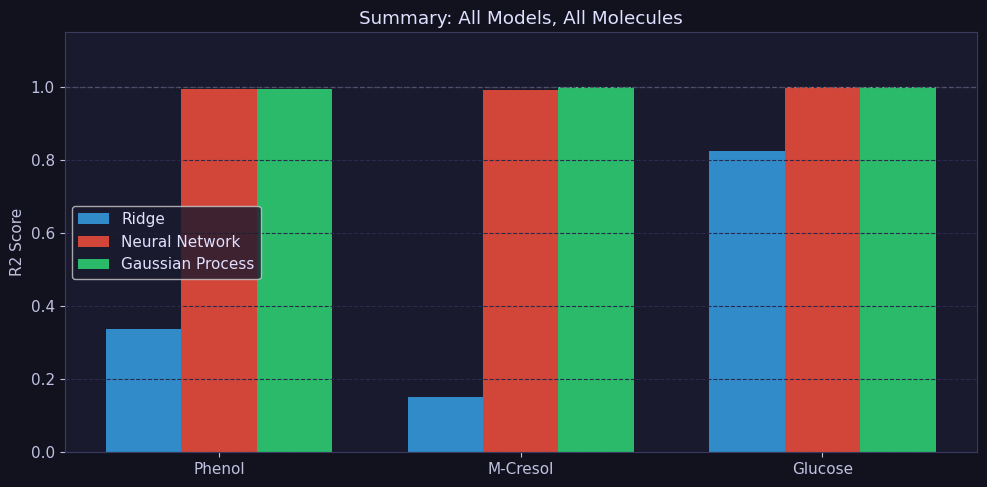

Notebook complete!


In [27]:
# Final summary R2 table
summary = []
for mol_name, df_mol in [('Phenol', ph), ('M-Cresol', mc), ('Glucose', gl)]:
    X, y = get_XY(df_mol)
    r = RegressionModel().fit(X, y).r2(X, y)
    n = NeuralNetworkModel().fit(X, y).r2(X, y)
    g = GaussianProcessModel().fit(X, y).r2(X, y)
    summary.append({'Molecule': mol_name, 'Ridge R2': round(r,3), 'NN R2': round(n,3), 'GP R2': round(g,3)})

df_summary = pd.DataFrame(summary)
print('=== Final R2 Summary ===')
print(df_summary.to_string(index=False))

# Bar chart
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(df_summary))
w = 0.25
ax.bar(x-w,   df_summary['Ridge R2'], w, label='Ridge', color='#3498db', alpha=0.9)
ax.bar(x,     df_summary['NN R2'],    w, label='Neural Network', color='#e74c3c', alpha=0.9)
ax.bar(x+w,   df_summary['GP R2'],    w, label='Gaussian Process', color='#2ecc71', alpha=0.9)
ax.set_xticks(x); ax.set_xticklabels(df_summary['Molecule'])
ax.set_ylabel('R2 Score'); ax.set_ylim(0, 1.15)
ax.set_title('Summary: All Models, All Molecules', color='#e0e0ff')
ax.legend()
ax.axhline(1.0, color='#ffffff30', lw=1, ls='--')
ax.grid(axis='y')
plt.tight_layout()
plt.show()
print('Notebook complete!')


---
## 12  How Do We Know the Model Is Actually Good?

> **The problem with our R² scores so far:** every R² we showed was measured on the *same data the model trained on.*
> That's like grading a student on the exam they already saw the answers to.
> A model can score R² = 0.99 by simply memorising the 7 data points — without learning anything useful.

We need a way to measure how well the model predicts **membranes it has never seen before**.


### 11.1  Leave-One-Out Cross-Validation (LOO-CV)

The idea is simple:

1. **Hide one data point** from the dataset
2. **Train the model** on all the remaining points
3. **Predict** the hidden point
4. **Record the error**
5. Repeat steps 1–4 for *every* data point
6. Compute R² across all the held-out predictions

```
Dataset: [M01, M02, M03, M04, M05, M06, M07]

Fold 1:  Train on [M02 M03 M04 M05 M06 M07]  →  predict M01
Fold 2:  Train on [M01 M03 M04 M05 M06 M07]  →  predict M02
  ...                  ...                          ...
Fold 7:  Train on [M01 M02 M03 M04 M05 M06]  →  predict M07

LOO R² = R²( [true M01..M07],  [predicted M01..M07] )
```

With only 7–8 data points, LOO is the **only statistically sound** way to estimate generalisation.
A standard 80/20 train-test split would leave only ~1–2 test points, which is too noisy to be meaningful.

The LOO R² tells you: *if you make a new membrane you've never tested, how accurately can the model predict its permeability?*


In [28]:
def run_loo(df, verbose=True):
    X, y = get_XY(df)
    N = len(X)
    preds = {'Ridge': np.zeros(N), 'NN': np.zeros(N), 'GP': np.zeros(N)}

    for i in range(N):
        # Build a boolean mask: everything except index i
        mask = np.ones(N, dtype=bool)
        mask[i] = False
        X_tr, y_tr = X[mask], y[mask]   # training set  (N-1 points)
        X_te = X[i:i+1]                 # test point    (1 point)

        preds['Ridge'][i] = RegressionModel().fit(X_tr, y_tr).predict(X_te)[0]
        preds['NN'][i]    = NeuralNetworkModel().fit(X_tr, y_tr).predict(X_te)[0]
        preds['GP'][i]    = GaussianProcessModel().fit(X_tr, y_tr).predict(X_te)[0]

    scores = {m: max(r2_score(y, preds[m]), -9.99) for m in preds}
    if verbose:
        for m, s in scores.items():
            print(f'  {m:20s}  LOO R2 = {s:+.3f}')
    return scores, preds, y

print('=== Phenol LOO Cross-Validation ===')
loo_ph, preds_ph, y_ph_true = run_loo(ph)
print()
print('=== M-Cresol LOO Cross-Validation ===')
loo_mc, preds_mc, y_mc_true = run_loo(mc)
print()
print('=== Glucose LOO Cross-Validation ===')
loo_gl, preds_gl, y_gl_true = run_loo(gl)


=== Phenol LOO Cross-Validation ===
  Ridge                 LOO R2 = -0.935
  NN                    LOO R2 = -2.593
  GP                    LOO R2 = -0.492

=== M-Cresol LOO Cross-Validation ===
  Ridge                 LOO R2 = -0.782
  NN                    LOO R2 = -6.881
  GP                    LOO R2 = -0.657

=== Glucose LOO Cross-Validation ===
  Ridge                 LOO R2 = +0.388
  NN                    LOO R2 = +0.897
  GP                    LOO R2 = +0.792


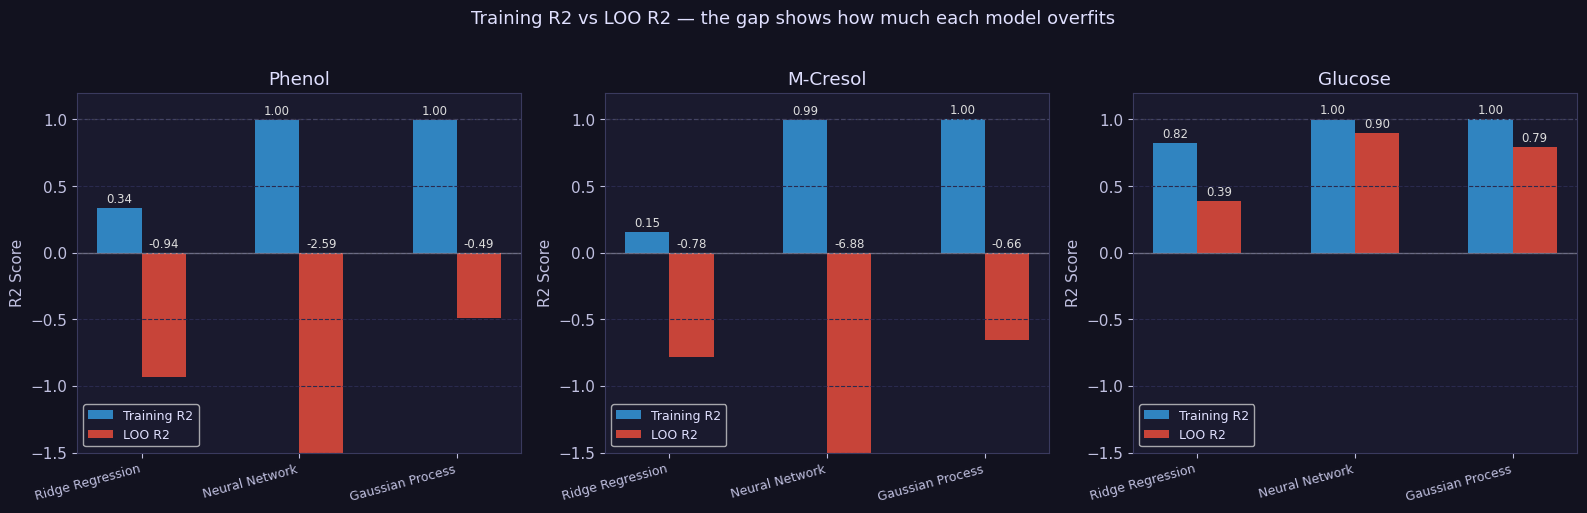

In [29]:
# Side-by-side: Training R2 vs LOO R2 for every model and molecule
model_keys  = ['Ridge', 'NN', 'GP']
model_names = ['Ridge Regression', 'Neural Network', 'Gaussian Process']
mol_data    = [('Phenol', ph, '#e74c3c'), ('M-Cresol', mc, '#9b59b6'), ('Glucose', gl, '#f39c12')]
loo_all     = {'Phenol': loo_ph, 'M-Cresol': loo_mc, 'Glucose': loo_gl}

# Compute training R2 for all
train_r2 = {}
for mol_name, df_mol, _ in mol_data:
    X, y = get_XY(df_mol)
    train_r2[mol_name] = {
        'Ridge': RegressionModel().fit(X, y).r2(X, y),
        'NN':    NeuralNetworkModel().fit(X, y).r2(X, y),
        'GP':    GaussianProcessModel().fit(X, y).r2(X, y),
    }

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
bar_w = 0.28
x = np.arange(len(model_names))

for ax, (mol_name, _, col) in zip(axes, mol_data):
    tr  = [train_r2[mol_name][k] for k in model_keys]
    loo = [loo_all[mol_name][k]  for k in model_keys]

    b1 = ax.bar(x - bar_w/2, tr,  bar_w, label='Training R2',  color='#3498db', alpha=0.85)
    b2 = ax.bar(x + bar_w/2, loo, bar_w, label='LOO R2',       color='#e74c3c', alpha=0.85)

    for b, v in [(b1, tr), (b2, loo)]:
        for bar, val in zip(b, v):
            ypos = max(bar.get_height(), 0) + 0.02
            ax.text(bar.get_x() + bar.get_width()/2, ypos, f'{val:.2f}',
                    ha='center', va='bottom', fontsize=8.5, color='#ddd')

    ax.axhline(0, color='#ffffff50', lw=1)
    ax.axhline(1, color='#ffffff20', lw=1, ls='--')
    ax.set_ylim(-1.5, 1.2)
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=15, ha='right', fontsize=9)
    ax.set_ylabel('R2 Score')
    ax.set_title(f'{mol_name}', color='#e0e0ff')
    ax.legend(fontsize=9)
    ax.grid(axis='y')

plt.suptitle('Training R2 vs LOO R2 — the gap shows how much each model overfits',
             color='#e0e0ff', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()


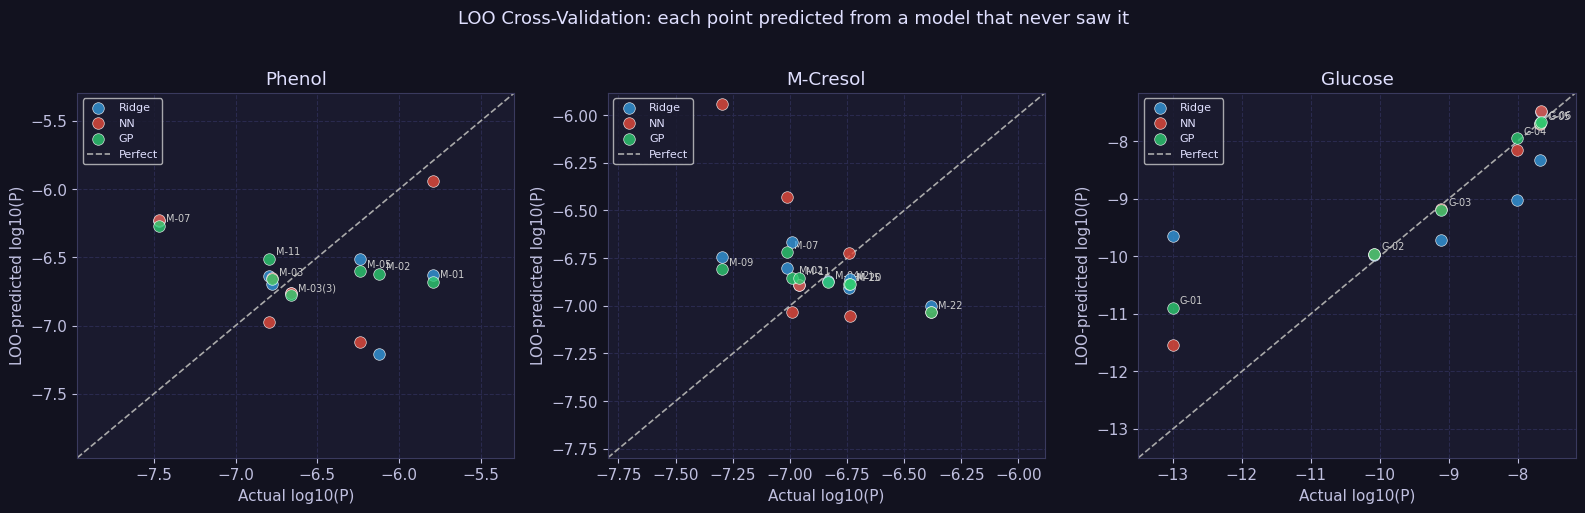


Interpretation guide:
  Points on the dashed line = perfect prediction
  Points far from the line  = the model failed to generalise to that membrane
  Negative LOO R2           = the model is worse than just predicting the mean


In [30]:
# For each molecule, show actual vs LOO-predicted points for the best model
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
all_preds = {'Phenol': preds_ph, 'M-Cresol': preds_mc, 'Glucose': preds_gl}
all_true  = {'Phenol': y_ph_true, 'M-Cresol': y_mc_true, 'Glucose': y_gl_true}
all_df    = {'Phenol': ph, 'M-Cresol': mc, 'Glucose': gl}

for ax, (mol_name, _, col) in zip(axes, mol_data):
    y_true = all_true[mol_name]
    preds  = all_preds[mol_name]
    df_mol = all_df[mol_name]

    # Plot all three models
    model_cols = {'Ridge': '#3498db', 'NN': '#e74c3c', 'GP': '#2ecc71'}
    for mk, mc_col in model_cols.items():
        ax.scatter(y_true, preds[mk], color=mc_col, s=70, alpha=0.8,
                   edgecolors='white', lw=0.5, label=mk, zorder=5)

    # Label each point with membrane ID
    for j, row in df_mol.reset_index(drop=True).iterrows():
        ax.annotate(row['id'], (y_true[j], preds['GP'][j]),
                    textcoords='offset points', xytext=(5, 3),
                    fontsize=7, color='#ccc')

    lims = [y_true.min() - 0.5, y_true.max() + 0.5]
    ax.plot(lims, lims, '--', color='#aaa', lw=1.2, label='Perfect')
    ax.set_xlim(lims); ax.set_ylim(lims)
    ax.set_xlabel('Actual log10(P)')
    ax.set_ylabel('LOO-predicted log10(P)')
    ax.set_title(f'{mol_name}', color='#e0e0ff')
    ax.legend(fontsize=8)
    ax.grid(True)

plt.suptitle('LOO Cross-Validation: each point predicted from a model that never saw it',
             color='#e0e0ff', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

print()
print('Interpretation guide:')
print('  Points on the dashed line = perfect prediction')
print('  Points far from the line  = the model failed to generalise to that membrane')
print('  Negative LOO R2           = the model is worse than just predicting the mean')


### 11.2  What Does a Negative LOO R² Mean?

R² can go **below zero** — that happens when the model's predictions are *worse* than simply guessing
the average permeability for every membrane. In other words, the model actively misleads you.

| LOO R² | What it means |
|--------|---------------|
| 0.90 + | Excellent — model generalises well to unseen compositions |
| 0.60 – 0.90 | Good — useful predictions, some uncertainty |
| 0.30 – 0.60 | Moderate — treat predictions as rough guidance only |
| 0.00 – 0.30 | Poor — barely better than guessing the average |
| < 0.00 | Bad — the model's predictions are actively misleading |

**Why does this happen with our data?**

We have very few data points (7–8) spread across a 4-dimensional space.
When you remove one point and retrain, the remaining 6–7 points may not adequately
cover the region near the held-out point — so the model extrapolates poorly.

> **Key takeaway:** Our training R² scores look great (≈ 0.99) because the models
> memorise the data. Our LOO R² scores reveal the honest truth: the models are
> uncertain in most of the composition space. **More experiments = better models.**


---
## 13  GP Uncertainty at the Optimal Composition

Unlike Ridge and Neural Network, the **Gaussian Process gives us a free gift: uncertainty estimates**.

At every composition $\mathbf{x}$, the GP doesn't just predict a single value —
it predicts a **full probability distribution**:

$$P(\mathbf{x}) \sim \mathcal{N}(\hat{\mu}(\mathbf{x}),\; \hat{\sigma}^2(\mathbf{x}))$$

- $\hat{\mu}(\mathbf{x})$ — the best guess (mean prediction)
- $\hat{\sigma}(\mathbf{x})$ — how uncertain the model is (standard deviation)

The further a composition is from any training point, the **larger $\hat{\sigma}$ becomes**.
This is exactly what we want — the model is honest about where it doesn't have data.

### 12.1  The 95% Confidence Interval

Working in log-space, a 95% CI for the true permeability is:

$$\log_{10}(P) \in \left[\hat{\mu} - 2\hat{\sigma},\; \hat{\mu} + 2\hat{\sigma}\right]$$

Converting back to linear space (cm/s):

$$P \in \left[10^{\hat{\mu} - 2\hat{\sigma}},\; 10^{\hat{\mu} + 2\hat{\sigma}}\right]$$

Because permeability is on a log scale, a $\sigma = 0.5$ log-unit uncertainty means
the true value could be **3× higher or lower** than the predicted value.
A $\sigma = 1.0$ means it could be **10× off**.


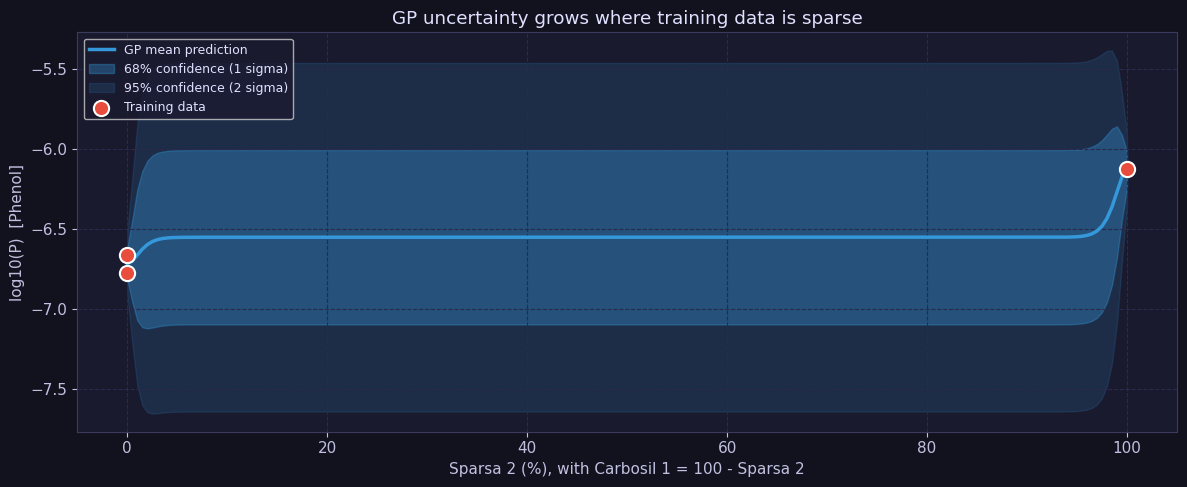

Notice: uncertainty is SMALLEST near training points (red dots)
        uncertainty is LARGEST in regions with no data


In [31]:
# Show how GP uncertainty grows as we move away from training data
# Fix S1=C2=0, sweep S2 from 0->100 (so C1 = 100-S2)
s2_sweep = np.linspace(0, 1, 200)
X_sweep  = np.column_stack([
    np.zeros(200),   # S1
    s2_sweep,        # S2
    1 - s2_sweep,    # C1
    np.zeros(200),   # C2
])

X_ph, y_ph_full = get_XY(ph)
gp_ph = GaussianProcessModel().fit(X_ph, y_ph_full)
mu, sigma = gp_ph.model.predict(X_sweep, return_std=True)

fig, ax = plt.subplots(figsize=(12, 5))

# Mean prediction
ax.plot(s2_sweep * 100, mu, color='#3498db', lw=2.5, label='GP mean prediction')

# 1-sigma band
ax.fill_between(s2_sweep * 100, mu - sigma, mu + sigma,
                alpha=0.35, color='#3498db', label='68% confidence (1 sigma)')

# 2-sigma band
ax.fill_between(s2_sweep * 100, mu - 2*sigma, mu + 2*sigma,
                alpha=0.15, color='#3498db', label='95% confidence (2 sigma)')

# Training data points
mask_slice = (X_ph[:, 0] < 0.05) & (X_ph[:, 3] < 0.05)
for j in range(len(X_ph)):
    if X_ph[j, 0] < 0.05 and X_ph[j, 3] < 0.05:
        ax.scatter(X_ph[j, 1]*100, y_ph_full[j], color='#e74c3c', s=120,
                   edgecolors='white', lw=1.5, zorder=6,
                   label='Training data' if j == np.where(mask_slice)[0][0] else '')

ax.set_xlabel('Sparsa 2 (%), with Carbosil 1 = 100 - Sparsa 2')
ax.set_ylabel('log10(P)  [Phenol]')
ax.set_title('GP uncertainty grows where training data is sparse', color='#e0e0ff')
ax.legend(fontsize=9)
ax.grid(True)
plt.tight_layout()
plt.show()

print('Notice: uncertainty is SMALLEST near training points (red dots)')
print('        uncertainty is LARGEST in regions with no data')


In [32]:
# Now find the optimal composition using GP and report uncertainty there
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from scipy.optimize import minimize

X_ph, y_ph_full = get_XY(ph)
X_mc, y_mc_full = get_XY(mc)
gp_ph = GaussianProcessModel().fit(X_ph, y_ph_full)
gp_mc = GaussianProcessModel().fit(X_mc, y_mc_full)
ph_min, ph_max = y_ph_full.min(), y_ph_full.max()
mc_min, mc_max = y_mc_full.min(), y_mc_full.max()

def objective(x):
    xr = x.reshape(1, -1)
    lp_ph = gp_ph.predict(xr)[0]
    lp_mc = gp_mc.predict(xr)[0]
    n_ph  = (lp_ph - ph_min) / (ph_max - ph_min + 1e-12)
    n_mc  = (lp_mc - mc_min) / (mc_max - mc_min + 1e-12)
    return n_ph + n_mc

constraints = [{'type': 'eq', 'fun': lambda x: x.sum() - 1}]
bounds = [(0, 1)] * 4

fixed_starts = [
    [1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1],
    [0.5,0.5,0,0], [0.5,0,0.5,0], [0,0.5,0.5,0],
    [0.25,0.25,0.25,0.25], [0,0.3,0.7,0], [0,0.5,0.5,0],
]
np.random.seed(0)
random_starts = [np.random.dirichlet(np.ones(4)) for _ in range(15)]
all_starts    = [np.array(s, dtype=float) / np.sum(s) for s in fixed_starts] + random_starts

best_val = np.inf; best_x = None
for x0 in all_starts:
    res = minimize(objective, x0, method='SLSQP', bounds=bounds,
                   constraints=constraints, options={'ftol': 1e-12, 'maxiter': 500})
    if res.success and res.fun < best_val:
        best_val = res.fun; best_x = res.x

best_x = np.maximum(best_x, 0); best_x /= best_x.sum()
labels = ['Sparsa 1', 'Sparsa 2', 'Carbosil 1', 'Carbosil 2']

print('=== Optimal Composition ===')
for l, v in zip(labels, best_x * 100):
    print(f'  {l}: {v:.1f}%')

# Get mean and uncertainty at optimal point
x_opt_2d = best_x.reshape(1, -1)
mu_ph, std_ph = gp_ph.model.predict(x_opt_2d, return_std=True)
mu_mc, std_mc = gp_mc.model.predict(x_opt_2d, return_std=True)

print()
print('=== Predictions at Optimal Composition ===')
print(f'  Phenol:')
print(f'    Predicted:  {10**mu_ph[0]:.3e} cm/s')
print(f'    Uncertainty: +/- {std_ph[0]:.2f} log-units (1 sigma)')
print(f'    95% CI:     {10**(mu_ph[0]-2*std_ph[0]):.2e}  to  {10**(mu_ph[0]+2*std_ph[0]):.2e} cm/s')
print()
print(f'  M-Cresol:')
print(f'    Predicted:  {10**mu_mc[0]:.3e} cm/s')
print(f'    Uncertainty: +/- {std_mc[0]:.2f} log-units (1 sigma)')
print(f'    95% CI:     {10**(mu_mc[0]-2*std_mc[0]):.2e}  to  {10**(mu_mc[0]+2*std_mc[0]):.2e} cm/s')


=== Optimal Composition ===
  Sparsa 1: 30.0%
  Sparsa 2: 70.0%
  Carbosil 1: 0.0%
  Carbosil 2: 0.0%

=== Predictions at Optimal Composition ===
  Phenol:
    Predicted:  3.554e-08 cm/s
    Uncertainty: +/- 0.11 log-units (1 sigma)
    95% CI:     2.12e-08  to  5.95e-08 cm/s

  M-Cresol:
    Predicted:  9.786e-08 cm/s
    Uncertainty: +/- 0.04 log-units (1 sigma)
    95% CI:     8.30e-08  to  1.15e-07 cm/s


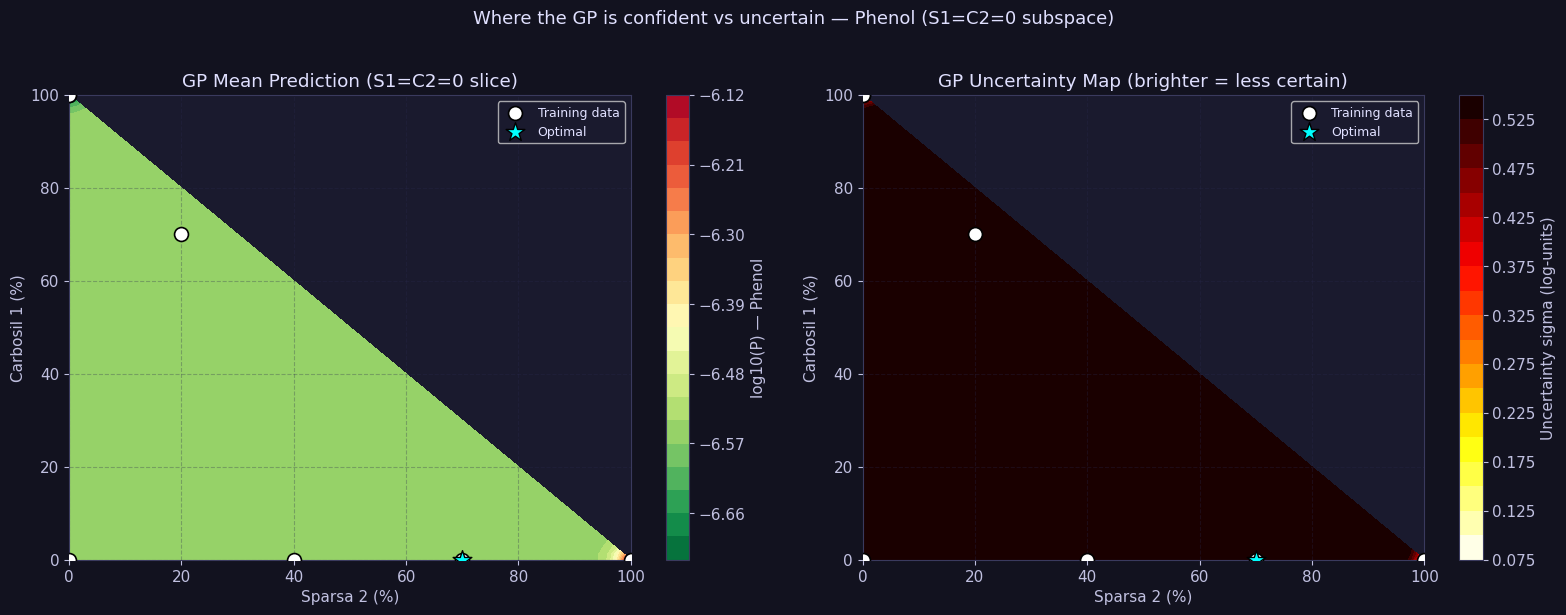

Optimal point (cyan star) is at S2=70.0%, C1=0.0%
Uncertainty there: sigma = 0.11 log-units for Phenol
                   sigma = 0.04 log-units for M-Cresol


In [33]:
# Visualise the uncertainty at the optimal point on the response surface
s2g = np.linspace(0, 1, 80)
c1g = np.linspace(0, 1, 80)
SS2, CC1 = np.meshgrid(s2g, c1g)
mask_grid = (SS2 + CC1) <= 1.0
X_grid = np.column_stack([np.zeros(SS2.size), SS2.ravel(), CC1.ravel(), np.zeros(SS2.size)])

mu_grid,  std_grid  = gp_ph.model.predict(X_grid, return_std=True)
mu_surf   = mu_grid.reshape(SS2.shape)
std_surf  = std_grid.reshape(SS2.shape)
mu_surf[~mask_grid]  = np.nan
std_surf[~mask_grid] = np.nan

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: mean prediction surface
im1 = ax1.contourf(SS2*100, CC1*100, mu_surf, levels=20, cmap='RdYlGn_r')
plt.colorbar(im1, ax=ax1, label='log10(P) — Phenol')
ax1.scatter(X_ph[:,1]*100, X_ph[:,2]*100, c='white', s=100, edgecolors='black', lw=1.2, zorder=6, label='Training data')
ax1.scatter(best_x[1]*100, best_x[2]*100, c='cyan', s=200, marker='*', edgecolors='black', lw=1, zorder=7, label='Optimal')
ax1.set_xlabel('Sparsa 2 (%)'); ax1.set_ylabel('Carbosil 1 (%)')
ax1.set_title('GP Mean Prediction (S1=C2=0 slice)', color='#e0e0ff')
ax1.legend(fontsize=9); ax1.grid(True, alpha=0.3)

# Right: uncertainty surface
im2 = ax2.contourf(SS2*100, CC1*100, std_surf, levels=20, cmap='hot_r')
plt.colorbar(im2, ax=ax2, label='Uncertainty sigma (log-units)')
ax2.scatter(X_ph[:,1]*100, X_ph[:,2]*100, c='white', s=100, edgecolors='black', lw=1.2, zorder=6, label='Training data')
ax2.scatter(best_x[1]*100, best_x[2]*100, c='cyan', s=200, marker='*', edgecolors='black', lw=1, zorder=7, label='Optimal')
ax2.set_xlabel('Sparsa 2 (%)'); ax2.set_ylabel('Carbosil 1 (%)')
ax2.set_title('GP Uncertainty Map (brighter = less certain)', color='#e0e0ff')
ax2.legend(fontsize=9); ax2.grid(True, alpha=0.3)

plt.suptitle('Where the GP is confident vs uncertain — Phenol (S1=C2=0 subspace)',
             color='#e0e0ff', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

print(f'Optimal point (cyan star) is at S2={best_x[1]*100:.1f}%, C1={best_x[2]*100:.1f}%')
print(f'Uncertainty there: sigma = {std_ph[0]:.2f} log-units for Phenol')
print(f'                   sigma = {std_mc[0]:.2f} log-units for M-Cresol')


### 12.2  What Should You Do With High Uncertainty?

If the uncertainty at the optimal composition is high, you have two choices:

**Option A — Run the experiment**
Make the membrane at the suggested composition and measure permeability.
Add the result to the dataset and retrain. The GP uncertainty will collapse around that point.

**Option B — Use the GP to pick the *next most informative* experiment (Active Learning)**

Instead of optimising just the mean prediction, optimise the **Lower Confidence Bound (LCB)**:

$$\mathbf{x}_{\text{next}} = \arg\min_{\mathbf{x}} \left[ \hat{\mu}(\mathbf{x}) - \kappa \cdot \hat{\sigma}(\mathbf{x}) \right]$$

- When $\kappa$ is **small** → the optimiser exploits the current best guess (greedy)
- When $\kappa$ is **large** → the optimiser explores uncertain regions (curious)

This is called **Bayesian Optimisation** and is used in drug discovery, materials science,
and chip design to find optima with the fewest experiments possible.

---
### Summary of Section 11–12

| Concept | What it tells you |
|---------|------------------|
| **Training R²** | How well the model memorises the data (always looks good) |
| **LOO R²** | How well the model predicts *new* membranes (the honest score) |
| **GP mean** | Best guess at any composition |
| **GP sigma** | How confident that guess is |
| **95% CI** | The range where the true permeability almost certainly lies |
| **Negative LOO R²** | The model is worse than guessing — need more data |


---
## 14  Bayesian Optimisation — Choosing the Next Experiment

### The core problem

We have 7–8 data points and a large composition space to explore.
Every experiment costs time and money.
**Which membrane should we make next to learn the most?**

Random guessing wastes experiments. The optimal-composition optimiser only exploits
what the model already knows — it ignores uncertainty entirely.

**Bayesian Optimisation** solves this properly.
It uses the GP's uncertainty estimates to reason about which experiment would be
most valuable: one that might give low permeability (exploitation) *or* one that
reduces our uncertainty in an unknown region (exploration).


### 13.1  The Acquisition Function: Expected Improvement (EI)

At each composition **x**, the GP gives us a probability distribution over the true permeability.
We can ask: *how much better than the current best result do we expect this point to be?*

Let $f^* = \min_i y_i$ be the best log-permeability we have seen so far.
The **Expected Improvement** is:

$$\text{EI}(\mathbf{x}) = \mathbb{E}\left[\max(f^* - f(\mathbf{x}),\ 0)\right]$$

Because the GP says $f(\mathbf{x}) \sim \mathcal{N}(\hat{\mu}, \hat{\sigma}^2)$, this expectation has a **closed form**:

$$z = \frac{f^* - \hat{\mu}(\mathbf{x}) - \xi}{\hat{\sigma}(\mathbf{x})}$$

$$\text{EI}(\mathbf{x}) = (f^* - \hat{\mu} - \xi)\,\Phi(z) + \hat{\sigma}\,\phi(z)$$

where $\Phi$ is the **normal CDF** and $\phi$ is the **normal PDF**, and $\xi \geq 0$ is an exploration parameter.

Breaking this down:
- $(f^* - \hat{\mu})\,\Phi(z)$ — reward for being **better than the current best** (exploitation term)
- $\hat{\sigma}\,\phi(z)$ — reward for **high uncertainty** (exploration term)
- $\xi$ — shifts the balance; larger $\xi$ pushes the optimiser to explore more

The next experiment is the composition that **maximises EI** over the simplex:

$$\mathbf{x}_{\text{next}} = \arg\max_{\mathbf{x}\,:\,\sum x_i=1} \text{EI}(\mathbf{x})$$


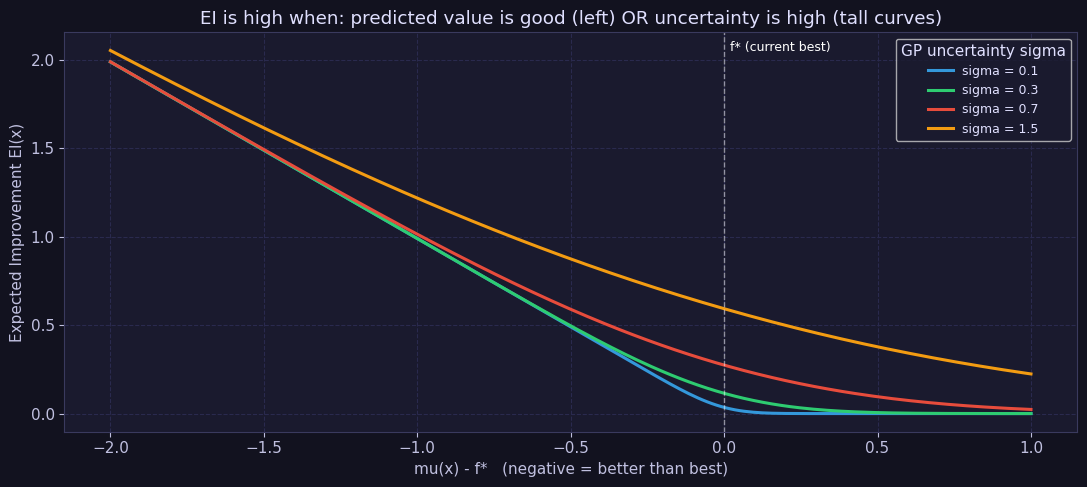

Key insight:
  - Even if mu(x) > f* (worse than best), EI > 0 when sigma is large
  - This is exploration: the model admits it might be wrong, so we should check


In [34]:
from scipy.stats import norm

# Show what EI looks like as a function of (mu - f_best) and sigma
f_best = 0.0  # normalise so f_best = 0
xi = 0.01

mu_range    = np.linspace(-2, 1, 200)   # x-axis: predicted mean relative to best
sigma_vals  = [0.1, 0.3, 0.7, 1.5]

fig, ax = plt.subplots(figsize=(11, 5))
colors_ei = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for sigma, col in zip(sigma_vals, colors_ei):
    z  = (f_best - mu_range - xi) / sigma
    ei = (f_best - mu_range - xi) * norm.cdf(z) + sigma * norm.pdf(z)
    ei = np.maximum(ei, 0)
    ax.plot(mu_range, ei, color=col, lw=2.2, label=f'sigma = {sigma}')

ax.axvline(0, color='white', lw=1, ls='--', alpha=0.5)
ax.text(0.02, ax.get_ylim()[1]*0.95, 'f* (current best)', color='white', fontsize=9)
ax.set_xlabel('mu(x) - f*   (negative = better than best)')
ax.set_ylabel('Expected Improvement EI(x)')
ax.set_title('EI is high when: predicted value is good (left) OR uncertainty is high (tall curves)',
             color='#e0e0ff')
ax.legend(title='GP uncertainty sigma', fontsize=9)
ax.grid(True)
plt.tight_layout()
plt.show()

print('Key insight:')
print('  - Even if mu(x) > f* (worse than best), EI > 0 when sigma is large')
print('  - This is exploration: the model admits it might be wrong, so we should check')


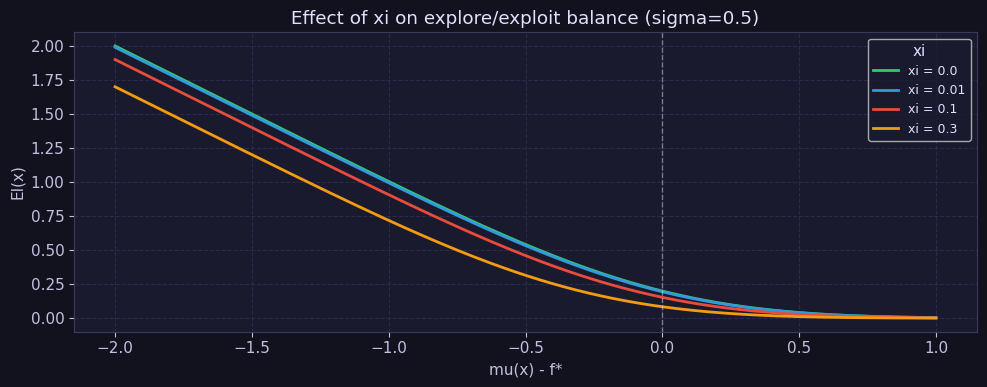

xi = 0.00 -> pure exploitation: only rewards beating f*
xi = 0.30 -> strong exploration: rewards being in uncertain regions even if not near f*


In [35]:
# Show how xi controls the explore/exploit trade-off
sigma = 0.5
mu_range = np.linspace(-2, 1, 200)
xi_vals = [0.0, 0.01, 0.1, 0.3]

fig, ax = plt.subplots(figsize=(10, 4))
colors_xi = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']

for xi_v, col in zip(xi_vals, colors_xi):
    z  = (f_best - mu_range - xi_v) / sigma
    ei = (f_best - mu_range - xi_v) * norm.cdf(z) + sigma * norm.pdf(z)
    ei = np.maximum(ei, 0)
    ax.plot(mu_range, ei, color=col, lw=2, label=f'xi = {xi_v}')

ax.axvline(0, color='white', lw=1, ls='--', alpha=0.4)
ax.set_xlabel('mu(x) - f*')
ax.set_ylabel('EI(x)')
ax.set_title('Effect of xi on explore/exploit balance (sigma=0.5)', color='#e0e0ff')
ax.legend(title='xi', fontsize=9)
ax.grid(True)
plt.tight_layout()
plt.show()

print('xi = 0.00 -> pure exploitation: only rewards beating f*')
print('xi = 0.30 -> strong exploration: rewards being in uncertain regions even if not near f*')


In [36]:
import sys
sys.path.insert(0, '/Users/matthewindelicarto/Desktop/Projects/Permeability Model')
from models import GaussianProcessModel, BayesianOptimiser

# Set up GPs on real data
X_ph, y_ph_full = get_XY(ph)
X_mc, y_mc_full = get_XY(mc)
gp_ph = GaussianProcessModel().fit(X_ph, y_ph_full)
gp_mc = GaussianProcessModel().fit(X_mc, y_mc_full)

# Run Bayesian Optimisation with xi = 0.01 (mostly exploit, slight exploration)
bo = BayesianOptimiser(gp_ph, gp_mc, y_ph_full, y_mc_full, xi=0.01)
suggestion = bo.suggest_next(n_restarts=40)

x_next = suggestion['x_opt']
labels = ['Sparsa 1', 'Sparsa 2', 'Carbosil 1', 'Carbosil 2']

print('=' * 50)
print('SUGGESTED NEXT MEMBRANE')
print('=' * 50)
for l, v in zip(labels, x_next * 100):
    if v > 0.05:
        print(f'  {l:15s}: {v:.1f}%')
print()
print(f'Expected Improvement score: {suggestion["acq_value"]:.5f}')
print()
print('What the GP predicts at this composition:')
print(f'  Phenol:   {suggestion["pred_ph"]:.3e} cm/s')
print(f'  95% CI:   {suggestion["ci95_ph"][0]:.2e}  to  {suggestion["ci95_ph"][1]:.2e}')
print(f'  Sigma:    {suggestion["std_ph"]:.3f} log-units')
print()
print(f'  M-Cresol: {suggestion["pred_mc"]:.3e} cm/s')
print(f'  95% CI:   {suggestion["ci95_mc"][0]:.2e}  to  {suggestion["ci95_mc"][1]:.2e}')
print(f'  Sigma:    {suggestion["std_mc"]:.3f} log-units')


SUGGESTED NEXT MEMBRANE
  Sparsa 1       : 29.3%
  Sparsa 2       : 70.7%

Expected Improvement score: 0.03780

What the GP predicts at this composition:
  Phenol:   5.006e-08 cm/s
  95% CI:   1.18e-08  to  2.13e-07
  Sigma:    0.315 log-units

  M-Cresol: 1.350e-07 cm/s
  95% CI:   4.29e-08  to  4.25e-07
  Sigma:    0.249 log-units


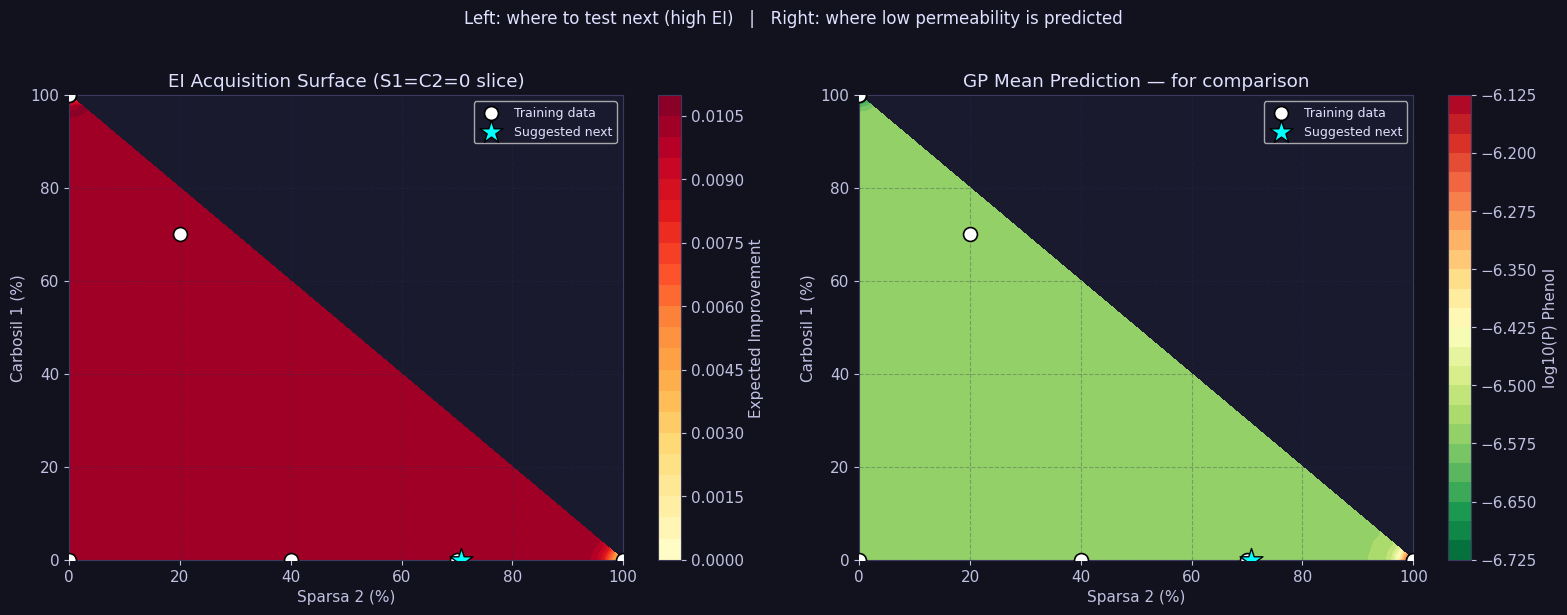

In [37]:
# Plot the EI acquisition surface across the S2 vs C1 subspace
SS, CC, EI_surf = bo.acquisition_surface(n=80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: EI surface
ax = axes[0]
im = ax.contourf(SS, CC, EI_surf, levels=25, cmap='YlOrRd')
plt.colorbar(im, ax=ax, label='Expected Improvement')
ax.scatter(X_ph[:, 1]*100, X_ph[:, 2]*100,
           c='white', s=100, edgecolors='black', lw=1.2, zorder=6, label='Training data')
ax.scatter(x_next[1]*100, x_next[2]*100,
           c='cyan', s=300, marker='*', edgecolors='black', lw=1, zorder=7, label='Suggested next')
ax.set_xlabel('Sparsa 2 (%)')
ax.set_ylabel('Carbosil 1 (%)')
ax.set_title('EI Acquisition Surface (S1=C2=0 slice)', color='#e0e0ff')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Right: GP mean prediction surface (for context)
s2g = np.linspace(0, 1, 80)
c1g = np.linspace(0, 1, 80)
SS2, CC1 = np.meshgrid(s2g, c1g)
mask = (SS2 + CC1) <= 1.0
X_grid = np.column_stack([np.zeros(SS2.size), SS2.ravel(), CC1.ravel(), np.zeros(SS2.size)])
mu_grid = gp_ph.model.predict(X_grid).reshape(SS2.shape)
mu_grid[~mask] = np.nan

ax2 = axes[1]
im2 = ax2.contourf(SS2*100, CC1*100, mu_grid, levels=25, cmap='RdYlGn_r')
plt.colorbar(im2, ax=ax2, label='log10(P) Phenol')
ax2.scatter(X_ph[:, 1]*100, X_ph[:, 2]*100,
            c='white', s=100, edgecolors='black', lw=1.2, zorder=6, label='Training data')
ax2.scatter(x_next[1]*100, x_next[2]*100,
            c='cyan', s=300, marker='*', edgecolors='black', lw=1, zorder=7, label='Suggested next')
ax2.set_xlabel('Sparsa 2 (%)')
ax2.set_ylabel('Carbosil 1 (%)')
ax2.set_title('GP Mean Prediction — for comparison', color='#e0e0ff')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.suptitle('Left: where to test next (high EI)   |   Right: where low permeability is predicted',
             color='#e0e0ff', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()


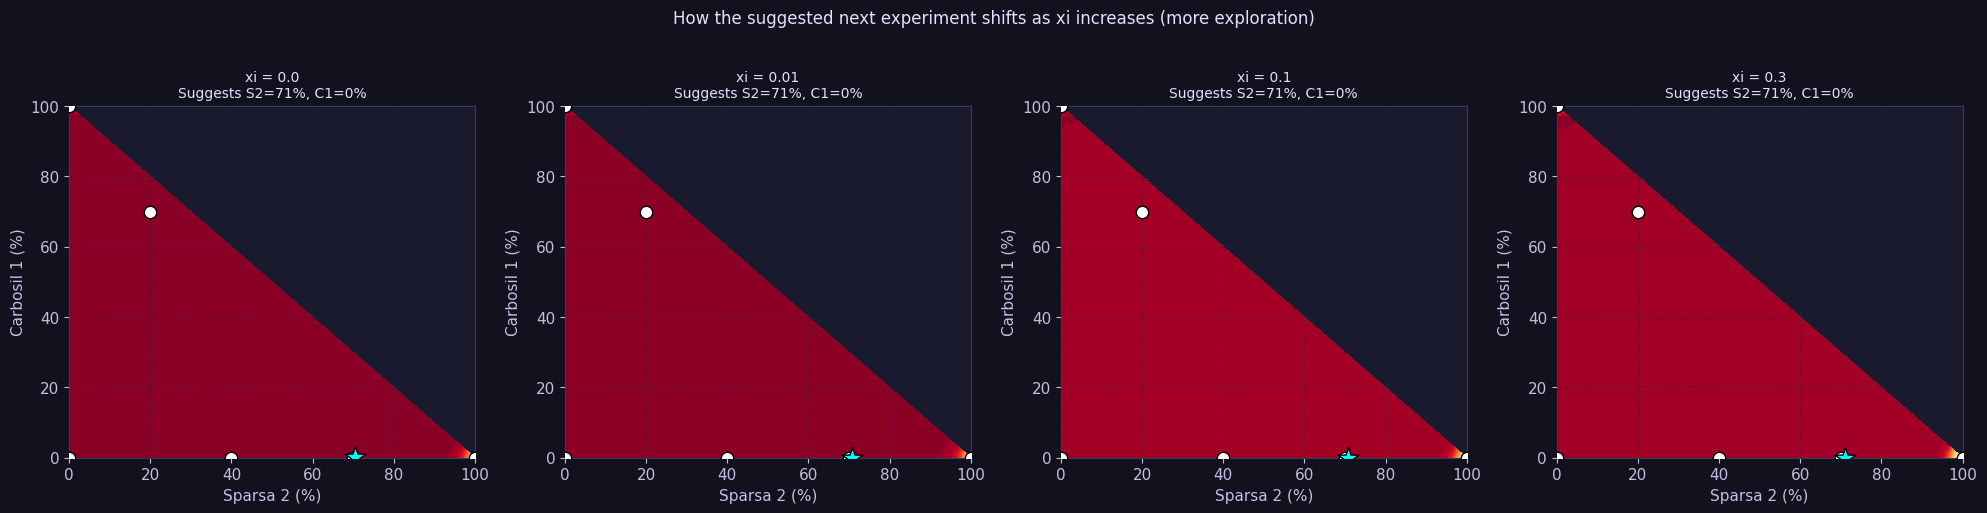

In [38]:
# Show how the suggestion changes with different xi values
xi_test_vals = [0.0, 0.01, 0.1, 0.3]
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax, xi_v in zip(axes, xi_test_vals):
    bo_v = BayesianOptimiser(gp_ph, gp_mc, y_ph_full, y_mc_full, xi=xi_v)
    sug_v = bo_v.suggest_next(n_restarts=20)
    SS_v, CC_v, EI_v = bo_v.acquisition_surface(n=60)

    im = ax.contourf(SS_v, CC_v, EI_v, levels=20, cmap='YlOrRd')
    ax.scatter(X_ph[:,1]*100, X_ph[:,2]*100,
               c='white', s=80, edgecolors='black', lw=1, zorder=6)
    ax.scatter(sug_v['x_opt'][1]*100, sug_v['x_opt'][2]*100,
               c='cyan', s=250, marker='*', edgecolors='black', lw=1, zorder=7)
    ax.set_title(f'xi = {xi_v}\nSuggests S2={sug_v["x_opt"][1]*100:.0f}%, C1={sug_v["x_opt"][2]*100:.0f}%',
                 color='#e0e0ff', fontsize=10)
    ax.set_xlabel('Sparsa 2 (%)')
    ax.set_ylabel('Carbosil 1 (%)')
    ax.grid(True, alpha=0.3)

plt.suptitle('How the suggested next experiment shifts as xi increases (more exploration)',
             color='#e0e0ff', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()


### 13.2  The Bayesian Optimisation Loop

In practice you would repeat this process iteratively:

```
1. Train GP on current data
2. Maximise EI to find x_next
3. Make membrane at x_next, measure permeability
4. Add (x_next, P_measured) to dataset
5. Go to step 1
```

Each iteration the model gets better and the EI surface changes.
Let's simulate what this would look like using our existing data —
we'll pretend we only have 3 data points and watch the BO loop add the rest one by one.


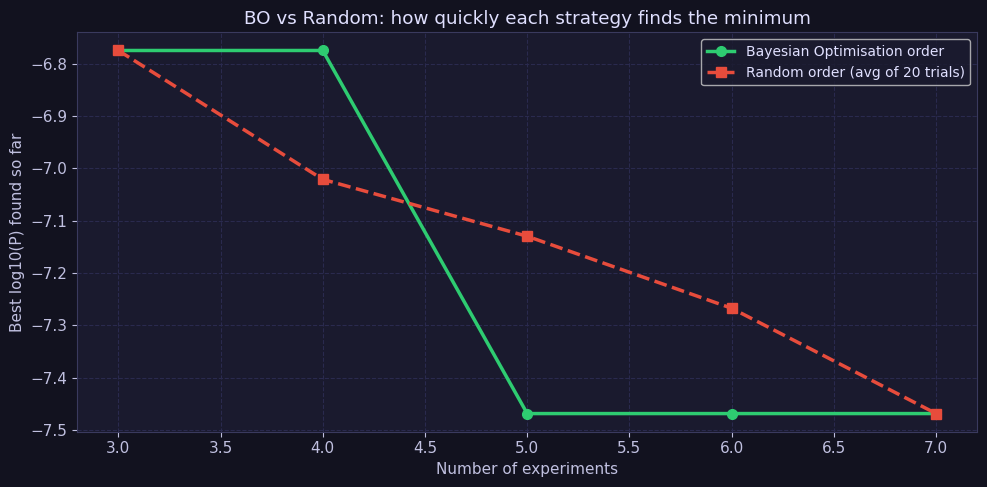

BO-guided experiment order (membrane indices):
  Step 1: M-01  (log P = -5.79)
  Step 2: M-02  (log P = -6.12)
  Step 3: M-03  (log P = -6.77)
  Step 4: M-05  (log P = -6.24)
  Step 5: M-07  (log P = -7.47)
  Step 6: M-11  (log P = -6.80)
  Step 7: M-03(3)  (log P = -6.66)


In [39]:
# Simulated BO loop: start with 3 phenol points, add the rest one at a time
# using EI to decide the order — then compare to random order

# All phenol data
X_all, y_all = get_XY(ph)
N_total = len(X_all)
N_init  = 3  # start with 3 points

# BO-guided order
np.random.seed(0)
init_idx = [0, 1, 2]  # start with M01, M02, M03
remaining = list(set(range(N_total)) - set(init_idx))

bo_order = list(init_idx)
X_known = X_all[init_idx].copy()
y_known = y_all[init_idx].copy()

# For MC we just use the full dataset as the second GP (simplification)
X_mc_full, y_mc_full2 = get_XY(mc)
gp_mc_fixed = GaussianProcessModel().fit(X_mc_full, y_mc_full2)

bo_best_vals = [y_known.min()]

for step in range(len(remaining)):
    gp_step = GaussianProcessModel().fit(X_known, y_known)
    bo_step = BayesianOptimiser(gp_step, gp_mc_fixed, y_known, y_mc_full2, xi=0.01)
    # Find which remaining point has highest EI
    ei_vals = [bo_step.acquisition(X_all[i]) for i in remaining]
    best_idx = remaining[np.argmax(ei_vals)]
    bo_order.append(best_idx)
    remaining.remove(best_idx)
    X_known = np.vstack([X_known, X_all[best_idx]])
    y_known = np.append(y_known, y_all[best_idx])
    bo_best_vals.append(y_known.min())

# Random order (average over 20 shuffles)
random_curves = []
for trial in range(20):
    np.random.seed(trial)
    rand_order = list(init_idx) + list(np.random.permutation(list(set(range(N_total)) - set(init_idx))))
    best_so_far = y_all[init_idx].min()
    curve = [best_so_far]
    for idx in rand_order[N_init:]:
        best_so_far = min(best_so_far, y_all[idx])
        curve.append(best_so_far)
    random_curves.append(curve)

random_mean = np.mean(random_curves, axis=0)

fig, ax = plt.subplots(figsize=(10, 5))
x_steps = np.arange(N_init, N_total + 1)
ax.plot(x_steps, bo_best_vals, color='#2ecc71', lw=2.5, marker='o', ms=7, label='Bayesian Optimisation order')
ax.plot(x_steps, random_mean,  color='#e74c3c', lw=2.5, ls='--', marker='s', ms=7, label='Random order (avg of 20 trials)')
ax.set_xlabel('Number of experiments')
ax.set_ylabel('Best log10(P) found so far')
ax.set_title('BO vs Random: how quickly each strategy finds the minimum', color='#e0e0ff')
ax.legend(fontsize=10)
ax.grid(True)
plt.tight_layout()
plt.show()

print('BO-guided experiment order (membrane indices):')
for step, idx in enumerate(bo_order):
    marker = ph.reset_index(drop=True).iloc[idx]['id']
    print(f'  Step {step+1}: {marker}  (log P = {y_all[idx]:.2f})')


### 13.3  Summary: When to Use Each Strategy

| Situation | Best approach |
|-----------|--------------|
| You have 5+ membranes and want the best blend now | **Optimal Composition** (SLSQP minimiser) |
| You want to know how reliable that suggestion is | **GP uncertainty + 95% CI** |
| You want to run one more experiment and don't know where | **Bayesian Optimisation (EI, xi=0.01)** |
| You have very few data points and the model is uncertain everywhere | **BO with high xi** (explore first) |
| You want to validate the model's reliability | **LOO cross-validation** |

**Practical workflow:**
1. Run LOO-CV first to know how much to trust the model
2. If LOO R² > 0.7: run the optimal composition directly
3. If LOO R² < 0.7: use BO to suggest the next experiment, then retrain and repeat

> The cyan star in the EI plots is not a magic answer — it is the composition that will teach
> the model the most with a single experiment. The more data you collect with BO guidance,
> the narrower the confidence intervals get, and the more reliable the optimal composition becomes.
